In [3]:
#########################################
### COVID_Wrangle_Preprocess for LSTM ###
#########################################

In [4]:
import os
import pandas as pd
import numpy as np
import category_encoders as ce
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.callbacks import EarlyStopping
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
# Set path and read file
path='D:\Documents-D\Becoming_a_DS_DE\Portfolio Design\PSU Classes\DAAN888\Data\Trade Datasets v2'
os.chdir(path)

df = pd.read_csv('combined_trade_v9.5_dateweeklycovidmissingduetopriorcovid_covid_DL.csv',low_memory=False)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6747499, 32)


In [6]:
df21 = df.drop(['DateTime_YearMonth','Year', 'DateTime_YearWeek','Date_Weekly_COVID', 'US_Port_State', 'Time0_StateCase',
                'cases_state_firstweek', 'Time0_StateDeath', 'deaths_state_firstweek', 
                'Metric_Tons_Weekly'], axis=1)
print(df21.shape)
print("\n")
def data_quality_table(df):
        mis_val = df.isnull().sum()
        #mis_val = df.isnull().sum().loc[lambda x : x>0] 
        #mis_val = df.loc[:, df.isna().any()].isna().sum()
        var_type = df.dtypes
        unique_count = df.nunique()
        mis_val_table = pd.concat([mis_val, var_type, unique_count], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Number Missing', 1 : 'Data Type', 2 : 'Number Unique'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'Number Missing', ascending=False).round(1)
        print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n")
        return mis_val_table_ren_columns

pd.set_option('display.max_columns', None)

print("\nData Quality Report") 
print(data_quality_table(df21))

(6747499, 22)



Data Quality Report
The selected dataframe has 22 columns.

                        Number Missing Data Type  Number Unique
Container_LCL/FCL                    0    object              2
Metric_Tons                          0   float64          78155
Date_Weekly_Agg                      0    object            731
deaths_pctdelta                      0   float64           1062
cases_pctdelta                       0   float64           1134
State_Closure_EA_Diff                0     int64              7
deaths_weekly                        0   float64           1062
cases_weekly                         0   float64           1135
State                                0    object             37
Average_Tariff                       0   float64            631
US_Unemployment_Rate                 0   float64             14
HS_Group_Name                        0    object              6
Foreign_Country_Region               0    object             11
US_Port_Coastal_Region     

In [7]:
#6 levels
(df21[['US_Port_Coastal_Region']].value_counts() / len(df21)) * 100

US_Port_Coastal_Region
Southwest                 30.190149
Northeast                 28.016959
Southeast                 18.534201
Northwest                 13.781151
Gulf                       8.542172
Other                      0.935369
dtype: float64

In [8]:
#11 levels
(df21[['Foreign_Country_Region']].value_counts() / len(df21)) * 100

Foreign_Country_Region           
China                                31.419108
European Union                       18.213771
Other East Asia (not China)          16.115853
Southeast Asia                       14.049265
South America                         5.996340
South Asia                            5.343165
North America                         3.972850
Middle East & North Africa            2.057147
Oceania                               1.978452
Other Europe (not European Union)     0.445869
Sub Saharan Africa                    0.408181
dtype: float64

In [9]:
#drop vice and pharma
(df21[['HS_Group_Name']].value_counts() / len(df21)) * 100

HS_Group_Name         
Finished Goods            54.822357
Edible                    12.771606
Edible with Processing    12.617223
Raw Input                 12.502425
Vices                      5.994399
Pharma                     1.291990
dtype: float64

In [10]:
#drop state but prob filter out subgroups later
df22 = df21.drop(['State', 'HS_Class'], axis=1)
print(df21.shape)
print("\n")
print(data_quality_table(df22))

(6747499, 22)


The selected dataframe has 20 columns.

                        Number Missing Data Type  Number Unique
Container_LCL/FCL                    0    object              2
Metric_Tons                          0   float64          78155
Date_Weekly_Agg                      0    object            731
deaths_pctdelta                      0   float64           1062
cases_pctdelta                       0   float64           1134
State_Closure_EA_Diff                0     int64              7
deaths_weekly                        0   float64           1062
cases_weekly                         0   float64           1135
Average_Tariff                       0   float64            631
US_Unemployment_Rate                 0   float64             14
HS_Group_Name                        0    object              6
Foreign_Country_Region               0    object             11
US_Port_Coastal_Region               0    object              6
foreign_company_size                 0    object

In [11]:
df23 = df22.drop(['Metric_Tons'], axis=1)
df24 = df22.loc[:, ['Metric_Tons']]
df22 = pd.concat([df24, df23], axis=1)
print(data_quality_table(df22))

The selected dataframe has 20 columns.

                        Number Missing Data Type  Number Unique
Metric_Tons                          0   float64          78155
Container_LCL/FCL                    0    object              2
Date_Weekly_Agg                      0    object            731
deaths_pctdelta                      0   float64           1062
cases_pctdelta                       0   float64           1134
State_Closure_EA_Diff                0     int64              7
deaths_weekly                        0   float64           1062
cases_weekly                         0   float64           1135
Average_Tariff                       0   float64            631
US_Unemployment_Rate                 0   float64             14
HS_Group_Name                        0    object              6
Foreign_Country_Region               0    object             11
US_Port_Coastal_Region               0    object              6
foreign_company_size                 0    object              6


In [12]:
df22 = df22.copy()
df22['DateTime']=pd.to_datetime(df22['DateTime']) 

In [13]:
df22.dtypes

Metric_Tons                      float64
Container_LCL/FCL                 object
Container_Type_Dry                  bool
TCVUSD                           float64
Trade_Direction                   object
DateTime                  datetime64[ns]
us_company_size                   object
foreign_company_size              object
US_Port_Coastal_Region            object
Foreign_Country_Region            object
HS_Group_Name                     object
US_Unemployment_Rate             float64
Average_Tariff                   float64
cases_weekly                     float64
deaths_weekly                    float64
State_Closure_EA_Diff              int64
cases_pctdelta                   float64
deaths_pctdelta                  float64
Date_Weekly_Agg                   object
Delta_Case0_Effective            float64
dtype: object

In [14]:
df22 = df22.copy()
df22['DateTime_YearWeek'] = df22['DateTime'].dt.strftime('%Y-w%U')

In [15]:
df22.loc[:,"Year"] = df22.DateTime.dt.year
print(df22[['Year']].value_counts())
#df22.sort_values('DateTime_YearWeek')
print(df22[['DateTime_YearWeek']].nunique())
#df22.head()
#df22.set_index('DateTime')
#df22.reset_index()

Year
2019    3429443
2020    3318056
dtype: int64
DateTime_YearWeek    106
dtype: int64


In [16]:
pd.set_option('display.max_rows', None)
df22[['DateTime_YearWeek']].value_counts()

#week 0 exists in the data

DateTime_YearWeek
2020-w41             76075
2020-w40             75209
2020-w35             74677
2020-w42             74336
2020-w32             73174
2020-w31             73088
2020-w37             72948
2020-w39             72769
2020-w33             72141
2019-w41             72058
2020-w43             71672
2020-w34             71214
2019-w38             71176
2019-w14             71058
2019-w06             70873
2019-w04             70672
2020-w01             70173
2020-w44             69852
2019-w19             69798
2020-w49             69791
2020-w30             69707
2019-w30             69579
2019-w44             69462
2019-w34             69351
2019-w37             69147
2019-w39             68667
2020-w38             68454
2019-w32             68443
2020-w48             68388
2019-w27             68127
2019-w33             68092
2019-w36             68045
2019-w28             67636
2019-w48             67526
2019-w31             67419
2019-w13             67043
2019-w18  

In [17]:
df23 = df22.drop(['Date_Weekly_Agg', 'DateTime'], axis=1)
#df22[['Date_Weekly_Agg']].value_counts()

In [18]:
#convert dtypes
df23 = df23.copy()
df22['State_Closure_EA_Diff'] = df22['State_Closure_EA_Diff'].astype('float64')

In [19]:
print(data_quality_table(df23))

The selected dataframe has 20 columns.

                        Number Missing Data Type  Number Unique
Metric_Tons                          0   float64          78155
Container_LCL/FCL                    0    object              2
DateTime_YearWeek                    0    object            106
Delta_Case0_Effective                0   float64             25
deaths_pctdelta                      0   float64           1062
cases_pctdelta                       0   float64           1134
State_Closure_EA_Diff                0     int64              7
deaths_weekly                        0   float64           1062
cases_weekly                         0   float64           1135
Average_Tariff                       0   float64            631
US_Unemployment_Rate                 0   float64             14
HS_Group_Name                        0    object              6
Foreign_Country_Region               0    object             11
US_Port_Coastal_Region               0    object              6


In [20]:
df23 = df23.sort_values('DateTime_YearWeek')
df23 = df23.set_index('DateTime_YearWeek')
df23.head()

,Metric_Tons,Container_LCL/FCL,Container_Type_Dry,TCVUSD,Trade_Direction,us_company_size,foreign_company_size,US_Port_Coastal_Region,Foreign_Country_Region,HS_Group_Name,US_Unemployment_Rate,Average_Tariff,cases_weekly,deaths_weekly,State_Closure_EA_Diff,cases_pctdelta,deaths_pctdelta,Delta_Case0_Effective,Year
DateTime_YearWeek,,,,,,,,,,,,,,,,,,,
2019-w00,17.01,FCL,True,56115.99,Import,medium,small,Northeast,China,Finished Goods,4.0,6.75,0.0,0.0,2,0.0,0.0,27.0,2019
2019-w00,0.15,LCL,True,1924.89,Import,medium,micro,Northeast,Other East Asia (not China),Finished Goods,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019
2019-w00,0.11,LCL,True,1548.30,Import,medium,micro,Northeast,Other East Asia (not China),Finished Goods,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019
2019-w00,0.23,LCL,True,3102.30,Import,medium,small,Northeast,Other East Asia (not China),Finished Goods,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019
2019-w00,2.44,LCL,True,32911.45,Import,medium,micro,Northeast,Other East Asia (not China),Finished Goods,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019


In [21]:
df23.shape

(6747499, 19)

In [22]:
df231 = df23.loc[df23['Metric_Tons'] < 250]
df231.shape

(6633785, 19)

In [23]:
print(df231[['Year']].value_counts())

Year
2019    3368492
2020    3265293
dtype: int64


In [24]:
df231.Metric_Tons.describe()

count    6.633785e+06
mean     2.171935e+01
std      3.123539e+01
min      0.000000e+00
25%      5.900000e+00
50%      1.417000e+01
75%      2.154000e+01
max      2.499900e+02
Name: Metric_Tons, dtype: float64

In [25]:
df231.Metric_Tons.max()

249.99

In [26]:
#cols = ['HS_Group_Name', 'Container_LCL/FCL', 'Foreign_Country_Region', 'US_Port_Coastal_Region', 'Trade_Direction']
df24 = pd.get_dummies(df231, prefix=['HS_Group_Name', 'Container_LCL/FCL', 'Foreign_Country_Region', 'US_Port_Coastal_Region', 'Trade_Direction', 'Container_Type_Dry'],
                      columns=['HS_Group_Name', 'Container_LCL/FCL', 'Foreign_Country_Region', 'US_Port_Coastal_Region', 'Trade_Direction', 'Container_Type_Dry'])


In [27]:
#currently 41
print(df24.shape)

df24.columns

(6633785, 42)


Index(['Metric_Tons', 'TCVUSD', 'us_company_size', 'foreign_company_size',
       'US_Unemployment_Rate', 'Average_Tariff', 'cases_weekly',
       'deaths_weekly', 'State_Closure_EA_Diff', 'cases_pctdelta',
       'deaths_pctdelta', 'Delta_Case0_Effective', 'Year',
       'HS_Group_Name_Edible', 'HS_Group_Name_Edible with Processing',
       'HS_Group_Name_Finished Goods', 'HS_Group_Name_Pharma',
       'HS_Group_Name_Raw Input', 'HS_Group_Name_Vices',
       'Container_LCL/FCL_FCL', 'Container_LCL/FCL_LCL',
       'Foreign_Country_Region_China', 'Foreign_Country_Region_European Union',
       'Foreign_Country_Region_Middle East & North Africa',
       'Foreign_Country_Region_North America',
       'Foreign_Country_Region_Oceania',
       'Foreign_Country_Region_Other East Asia (not China)',
       'Foreign_Country_Region_Other Europe (not European Union)',
       'Foreign_Country_Region_South America',
       'Foreign_Country_Region_South Asia',
       'Foreign_Country_Region_Southeas

In [28]:
X = df24.iloc[:,:-1]
y = df24.iloc[:,:1]
#X = scaled[:][:-1] # All of the above columns and remove readings from last 24 hours
#y = scaled[:, 0][1:] # Appliances or the target/label column and remove readings from first 24 hours
print(X.shape)
print(y.shape)
y.head()

(6633785, 41)
(6633785, 1)


,Metric_Tons
DateTime_YearWeek,
2019-w00,17.01
2019-w00,0.15
2019-w00,0.11
2019-w00,0.23
2019-w00,2.44


In [29]:
#encode using ranking - ordinal             
#import category_encoders as ce   
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
result = ce_ord.fit_transform(X, y['Metric_Tons'])

C:\Users\aschu\miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [30]:
result.head()

,Metric_Tons,TCVUSD,us_company_size,foreign_company_size,US_Unemployment_Rate,Average_Tariff,cases_weekly,deaths_weekly,State_Closure_EA_Diff,cases_pctdelta,deaths_pctdelta,Delta_Case0_Effective,Year,HS_Group_Name_Edible,HS_Group_Name_Edible with Processing,HS_Group_Name_Finished Goods,HS_Group_Name_Pharma,HS_Group_Name_Raw Input,HS_Group_Name_Vices,Container_LCL/FCL_FCL,Container_LCL/FCL_LCL,Foreign_Country_Region_China,Foreign_Country_Region_European Union,Foreign_Country_Region_Middle East & North Africa,Foreign_Country_Region_North America,Foreign_Country_Region_Oceania,Foreign_Country_Region_Other East Asia (not China),Foreign_Country_Region_Other Europe (not European Union),Foreign_Country_Region_South America,Foreign_Country_Region_South Asia,Foreign_Country_Region_Southeast Asia,Foreign_Country_Region_Sub Saharan Africa,US_Port_Coastal_Region_Gulf,US_Port_Coastal_Region_Northeast,US_Port_Coastal_Region_Northwest,US_Port_Coastal_Region_Other,US_Port_Coastal_Region_Southeast,US_Port_Coastal_Region_Southwest,Trade_Direction_Export,Trade_Direction_Import,Container_Type_Dry_False
DateTime_YearWeek,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-w00,17.01,56115.99,1,1,4.0,6.75,0.0,0.0,2,0.0,0.0,27.0,2019,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2019-w00,0.15,1924.89,1,2,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2019-w00,0.11,1548.30,1,2,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2019-w00,0.23,3102.30,1,1,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2019-w00,2.44,32911.45,1,2,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [31]:
result.shape

(6633785, 41)

In [32]:
print(data_quality_table(result))

The selected dataframe has 41 columns.

                                                    Number Missing Data Type  \
Metric_Tons                                                      0   float64   
Foreign_Country_Region_China                                     0     uint8   
Foreign_Country_Region_Middle East & North Africa                0     uint8   
Foreign_Country_Region_North America                             0     uint8   
Foreign_Country_Region_Oceania                                   0     uint8   
Foreign_Country_Region_Other East Asia (not China)               0     uint8   
Foreign_Country_Region_Other Europe (not Europe...               0     uint8   
Foreign_Country_Region_South America                             0     uint8   
Foreign_Country_Region_South Asia                                0     uint8   
Foreign_Country_Region_Southeast Asia                            0     uint8   
Foreign_Country_Region_Sub Saharan Africa                        0     uint8   


In [33]:
result = result.reset_index()
result.head()
#df22.set_index('DateTime')
#df22.reset_index()
#result[['Date_Weekly_Agg']].nunique()

,DateTime_YearWeek,Metric_Tons,TCVUSD,us_company_size,foreign_company_size,US_Unemployment_Rate,Average_Tariff,cases_weekly,deaths_weekly,State_Closure_EA_Diff,cases_pctdelta,deaths_pctdelta,Delta_Case0_Effective,Year,HS_Group_Name_Edible,HS_Group_Name_Edible with Processing,HS_Group_Name_Finished Goods,HS_Group_Name_Pharma,HS_Group_Name_Raw Input,HS_Group_Name_Vices,Container_LCL/FCL_FCL,Container_LCL/FCL_LCL,Foreign_Country_Region_China,Foreign_Country_Region_European Union,Foreign_Country_Region_Middle East & North Africa,Foreign_Country_Region_North America,Foreign_Country_Region_Oceania,Foreign_Country_Region_Other East Asia (not China),Foreign_Country_Region_Other Europe (not European Union),Foreign_Country_Region_South America,Foreign_Country_Region_South Asia,Foreign_Country_Region_Southeast Asia,Foreign_Country_Region_Sub Saharan Africa,US_Port_Coastal_Region_Gulf,US_Port_Coastal_Region_Northeast,US_Port_Coastal_Region_Northwest,US_Port_Coastal_Region_Other,US_Port_Coastal_Region_Southeast,US_Port_Coastal_Region_Southwest,Trade_Direction_Export,Trade_Direction_Import,Container_Type_Dry_False
0,2019-w00,17.01,56115.99,1,1,4.0,6.75,0.0,0.0,2,0.0,0.0,27.0,2019,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,2019-w00,0.15,1924.89,1,2,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,2019-w00,0.11,1548.30,1,2,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,2019-w00,0.23,3102.30,1,1,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2019-w00,2.44,32911.45,1,2,4.0,0.10,0.0,0.0,2,0.0,0.0,27.0,2019,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [34]:
#result[['Date_Weekly_Agg']].value_counts()

In [35]:

result[['Year']].value_counts()


Year
2019    3368492
2020    3265293
dtype: int64

In [36]:
result.columns

Index(['DateTime_YearWeek', 'Metric_Tons', 'TCVUSD', 'us_company_size',
       'foreign_company_size', 'US_Unemployment_Rate', 'Average_Tariff',
       'cases_weekly', 'deaths_weekly', 'State_Closure_EA_Diff',
       'cases_pctdelta', 'deaths_pctdelta', 'Delta_Case0_Effective', 'Year',
       'HS_Group_Name_Edible', 'HS_Group_Name_Edible with Processing',
       'HS_Group_Name_Finished Goods', 'HS_Group_Name_Pharma',
       'HS_Group_Name_Raw Input', 'HS_Group_Name_Vices',
       'Container_LCL/FCL_FCL', 'Container_LCL/FCL_LCL',
       'Foreign_Country_Region_China', 'Foreign_Country_Region_European Union',
       'Foreign_Country_Region_Middle East & North Africa',
       'Foreign_Country_Region_North America',
       'Foreign_Country_Region_Oceania',
       'Foreign_Country_Region_Other East Asia (not China)',
       'Foreign_Country_Region_Other Europe (not European Union)',
       'Foreign_Country_Region_South America',
       'Foreign_Country_Region_South Asia',
       'Foreign_Co

In [37]:
result = result.set_index('DateTime_YearWeek')
result = result.drop(['Year'], axis=1)
#result.head()

In [38]:
result.shape

(6633785, 40)

In [39]:
# prepare data for lstm


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = result
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.068043   0.000036        0.0        0.0   0.044248    0.00407   
2   0.000600   0.000001        0.0        0.2   0.044248    0.00006   
3   0.000440   0.000001        0.0        0.2   0.044248    0.00006   
4   0.000920   0.000002        0.0        0.0   0.044248    0.00006   
5   0.009760   0.000021        0.0        0.2   0.044248    0.00006   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1        0.0        0.0      0.125         0.0    0.000004    0.301587   
2        0.0        0.0      0.125         0.0    0.000004    0.301587   
3        0.0        0.0      0.125         0.0    0.000004    0.301587   
4        0.0        0.0      0.125         0.0    0.000004    0.301587   
5        0.0        0.0      0.125         0.0    0.000004    0.301587   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  \
1         0.0         0.0         1.0         0.0  

In [40]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.068043   0.000036        0.0        0.0   0.044248    0.00407   
2   0.000600   0.000001        0.0        0.2   0.044248    0.00006   
3   0.000440   0.000001        0.0        0.2   0.044248    0.00006   
4   0.000920   0.000002        0.0        0.0   0.044248    0.00006   
5   0.009760   0.000021        0.0        0.2   0.044248    0.00006   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1        0.0        0.0      0.125         0.0    0.000004    0.301587   
2        0.0        0.0      0.125         0.0    0.000004    0.301587   
3        0.0        0.0      0.125         0.0    0.000004    0.301587   
4        0.0        0.0      0.125         0.0    0.000004    0.301587   
5        0.0        0.0      0.125         0.0    0.000004    0.301587   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  \
1         0.0         0.0         1.0         0.0  

In [41]:
#define fit model for 2019
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)


In [42]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.4.1
Eager execution is: True
Keras version: 2.4.0
Num GPUs Available:  1


In [45]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#stopped due to increase in val_loss
#,callbacks=[tensorboard_callback]
history = model.fit(train_X, train_y, epochs=30, batch_size=128, shuffle=False)

Epoch 1/30


In [ ]:
#

In [312]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.15))
model.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()



Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 100)               56400     
_________________________________________________________________
dropout_22 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 101       
Total params: 56,501
Trainable params: 56,501
Non-trainable params: 0
_________________________________________________________________


In [40]:
%load_ext tensorboard

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
%tensorboard --logdir logs

In [302]:
#stopped due to increase in val_loss
history = model.fit(train_X, train_y, epochs=30,validation_data=(test_X, test_y), batch_size=16, shuffle=False,
                    callbacks=[tensorboard_callback])


Epoch 1/30
210531/210531 [==============================] - 2686s 13ms/step - loss: 0.0142 - mae: 0.0661 - val_loss: 0.0132 - val_mae: 0.0691
Epoch 2/30
210531/210531 [==============================] - 2655s 13ms/step - loss: 0.0140 - mae: 0.0652 - val_loss: 0.0134 - val_mae: 0.0718
Epoch 3/30
210531/210531 [==============================] - 2704s 13ms/step - loss: 0.0140 - mae: 0.0651 - val_loss: 0.0135 - val_mae: 0.0730
Epoch 4/30
210531/210531 [==============================] - 2711s 13ms/step - loss: 0.0140 - mae: 0.0650 - val_loss: 0.0137 - val_mae: 0.0763
Epoch 5/30
210531/210531 [==============================] - 2350s 11ms/step - loss: 0.0139 - mae: 0.0649 - val_loss: 0.0139 - val_mae: 0.0779
Epoch 6/30
210531/210531 [==============================] - 2374s 11ms/step - loss: 0.0139 - mae: 0.0649 - val_loss: 0.0143 - val_mae: 0.0804
Epoch 7/30
210531/210531 [==============================] - 2639s 13ms/step - loss: 0.0139 - mae: 0.0649 - val_loss: 0.0153 - val_mae: 0.0847
Epoch 

KeyboardInterrupt: 

In [313]:
filepath='best_model_val_loss'


callbacks_list = [EarlyStopping(monitor='val_loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True)]
              
history = model.fit(train_X, train_y, epochs=30,validation_data=(test_X, test_y), batch_size=16, shuffle=False,
                    callbacks = callbacks_list)

Epoch 1/30
210531/210531 [==============================] - 2631s 12ms/step - loss: 0.0142 - mae: 0.0661 - val_loss: 0.0131 - val_mae: 0.0677
INFO:tensorflow:Assets written to: best_model_val_loss\assets
Epoch 2/30
210531/210531 [==============================] - 2224s 11ms/step - loss: 0.0140 - mae: 0.0651 - val_loss: 0.0132 - val_mae: 0.0701
Epoch 3/30
210531/210531 [==============================] - 2350s 11ms/step - loss: 0.0140 - mae: 0.0650 - val_loss: 0.0134 - val_mae: 0.0729
Epoch 4/30
210531/210531 [==============================] - 2746s 13ms/step - loss: 0.0139 - mae: 0.0649 - val_loss: 0.0137 - val_mae: 0.0762


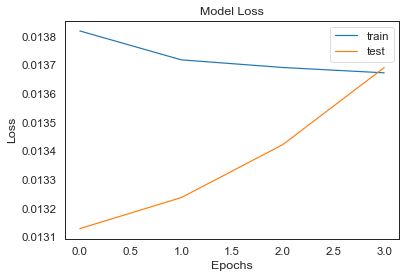

In [314]:
from matplotlib import pyplot
# plot history
plt.title('Model Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [315]:
#Make Predictions
# create empty table with 40fields
#, 40)
train_predict = model.predict(train_X)
train_predict_dataset_like = np.zeros(shape=(len(train_predict), 40))
# put the predicted values in the right field
train_predict_dataset_like[:,0] = train_predict[:,0]
# inverse transform and then select the right field
train_predict = scaler.inverse_transform(train_predict_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict[:])))

Train Mean Absolute Error: 22.878843886727353
Train Root Mean Squared Error: 25.90061144700793


In [316]:
test_predict = model.predict(test_X)
test_predict_dataset_like = np.zeros(shape=(len(test_predict), 40))
# invert predictions
test_predict_dataset_like[:,0] = test_predict[:,0]
# inverse transform and then select the right field
test_predict = scaler.inverse_transform(test_predict_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict[:])))

Test Mean Absolute Error: 27.55737854931846
Test Root Mean Squared Error: 29.56128959366086


In [317]:


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))


In [338]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


In [339]:
np.amax(inv_yhat)

171.50941

In [340]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [341]:
inv_y

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [342]:
np.amax(inv_y)

249.99

In [343]:
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y, inv_yhat))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y, inv_yhat))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))
#print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.r2_score(inv_y, inv_yhat))

Mean Absolute Error (MAE): 19.042728
Mean Square Error (MSE): 855.676758


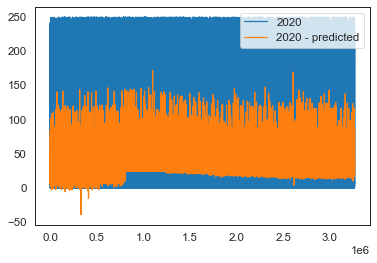

In [344]:
plt.plot(inv_y, label = '2020')
plt.plot(inv_yhat, label = '2020 - predicted')
plt.legend()
plt.show()

In [ ]:
#

In [41]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.15))
model.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 56,501
Trainable params: 56,501
Non-trainable params: 0
_________________________________________________________________


In [64]:
filepath='best_model_val_loss'

checkpoint_dir = os.path.dirname(filepath)

callbacks_list = [EarlyStopping(monitor='mae', patience = 5),
                  ModelCheckpoint(filepath, monitor='mae', save_weights_only=True)]

In [42]:
history = model.fit(train_X, train_y, epochs=30,validation_data=(test_X, test_y), batch_size=32, shuffle=False,
                    callbacks = callbacks_list)

Epoch 1/30
105266/105266 [==============================] - 1384s 13ms/step - loss: 0.0142 - mae: 0.0661 - val_loss: 0.0130 - val_mae: 0.0641
INFO:tensorflow:Assets written to: best_model_val_loss\assets
Epoch 2/30
105266/105266 [==============================] - 1287s 12ms/step - loss: 0.0140 - mae: 0.0651 - val_loss: 0.0131 - val_mae: 0.0654
INFO:tensorflow:Assets written to: best_model_val_loss\assets
Epoch 3/30
105266/105266 [==============================] - 1363s 13ms/step - loss: 0.0139 - mae: 0.0649 - val_loss: 0.0131 - val_mae: 0.0666
INFO:tensorflow:Assets written to: best_model_val_loss\assets
Epoch 4/30
105266/105266 [==============================] - 1369s 13ms/step - loss: 0.0139 - mae: 0.0648 - val_loss: 0.0131 - val_mae: 0.0668
INFO:tensorflow:Assets written to: best_model_val_loss\assets
Epoch 5/30
105266/105266 [==============================] - 1289s 12ms/step - loss: 0.0139 - mae: 0.0648 - val_loss: 0.0132 - val_mae: 0.0685
INFO:tensorflow:Assets written to: best_mo

In [78]:
tf.saved_model.Asset(
    path
)

In [81]:
tf.saved_model.load(
    filepath, tags=None, options=None
)


OSError: SavedModel file does not exist at: best_model_val_loss.h5py/{saved_model.pbtxt|saved_model.pb}

model.save('D:\Documents-D\Becoming_a_DS_DE\Portfolio Design\PSU Classes\DAAN888\')

In [83]:
from tensorflow import keras
model1 = keras.models.load_model('D:\Documents-D\Becoming_a_DS_DE\Portfolio Design\PSU Classes\DAAN888\Data\Trade Datasets v2\best_model_val_loss\saved_model.pb')

OSError: SavedModel file does not exist at: D:\Documents-D\Becoming_a_DS_DE\Portfolio Design\PSU Classes\DAAN888\Data\Trade Datasets v2est_model_val_loss\saved_model.pb/{saved_model.pbtxt|saved_model.pb}

In [73]:
import os
filepath='best_model_val_loss'

checkpoint_dir = os.path.dirname(filepath)

os.listdir(checkpoint_dir)

FileNotFoundError: [WinError 3] The system cannot find the path specified: ''

In [74]:
model.load_weights(filepath)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for best_model_val_loss.h5py

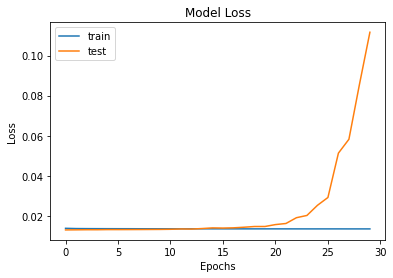

In [45]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
# plot history
plt.title('Model Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [47]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
#Make Predictions
# create empty table with 40fields
train_predict = model.predict(train_X)
train_predict_dataset_like = np.zeros(shape=(len(train_predict), 40))
# put the predicted values in the right field
train_predict_dataset_like[:,0] = train_predict[:,0]
# inverse transform and then select the right field
train_predict = scaler.inverse_transform(train_predict_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict[:])))

Train Mean Absolute Error: 23.739434284251224
Train Root Mean Squared Error: 26.670704313974003


In [48]:
test_predict = model.predict(test_X)
test_predict_dataset_like = np.zeros(shape=(len(test_predict), 40))
# invert predictions
test_predict_dataset_like[:,0] = test_predict[:,0]
# inverse transform and then select the right field
test_predict = scaler.inverse_transform(test_predict_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict[:])))

Test Mean Absolute Error: 38.97406377656311
Test Root Mean Squared Error: 88.01374178069595


In [49]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))


In [51]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]



In [52]:
inv_yhat



array([24.675936, 24.61748 , 20.739979, ..., 26.678137, 28.120295,
       31.904398], dtype=float32)

In [53]:
np.amax(inv_yhat)



4101.987

In [54]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]



In [55]:
inv_y



array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [56]:
np.amax(inv_y)



249.99

In [57]:
np.average(inv_y)

21.535181

In [58]:
np.average(inv_yhat)

39.0601

In [59]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y, inv_yhat))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y, inv_yhat))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))
#print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.r2_score(inv_y, inv_yhat))

Mean Absolute Error (MAE): 28.824310
Mean Square Error (MSE): 6974.477051


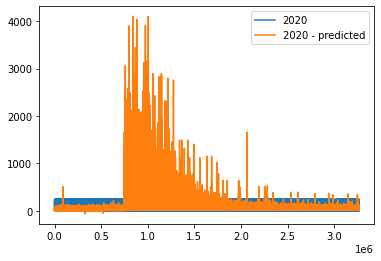

In [60]:
plt.plot(inv_y, label = '2020')
plt.plot(inv_yhat, label = '2020 - predicted')
plt.legend()
plt.show()

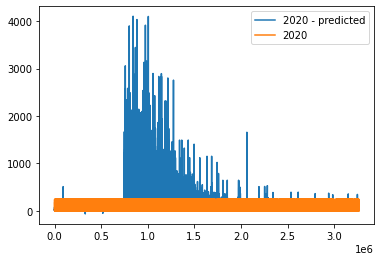

In [63]:
plt.plot(inv_yhat, label = '2020 - predicted')
plt.plot(inv_y, label = '2020')
plt.legend()
plt.show()

In [87]:
#return to this from medium site
new_model = model()
get_test_val_loss(new_model, test_X, test_y)

ValueError: The first argument to `Layer.call` must always be passed.

In [ ]:
#

In [115]:
#define fit model for 2019
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)


In [85]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model1 = Sequential()
model1.add(LSTM(100, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dropout(0.15))
model1.add(Dense(1))

# fit network
model1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 56,501
Trainable params: 56,501
Non-trainable params: 0
_________________________________________________________________


In [90]:
filepath='weights_only_train2019_test2020'

checkpoint_dir = os.path.dirname(filepath)

callbacks_list = [EarlyStopping(monitor='mae', patience = 5),
                  ModelCheckpoint(filepath, monitor='mae', save_freq='epoch', save_weights_only=True)]


In [91]:
pwd

'D:\\Documents-D\\Becoming_a_DS_DE\\Portfolio Design\\PSU Classes\\DAAN888\\Data\\Trade Datasets v2'

In [92]:
history1 = model1.fit(train_X, train_y, epochs=20,validation_data=(test_X, test_y), batch_size=64, shuffle=False,
                    callbacks = callbacks_list)

Epoch 1/20
52633/52633 [==============================] - 409s 8ms/step - loss: 0.0142 - mae: 0.0661 - val_loss: 0.0130 - val_mae: 0.0655
Epoch 2/20
52633/52633 [==============================] - 386s 7ms/step - loss: 0.0140 - mae: 0.0650 - val_loss: 0.0131 - val_mae: 0.0665
Epoch 3/20
52633/52633 [==============================] - 417s 8ms/step - loss: 0.0139 - mae: 0.0649 - val_loss: 0.0131 - val_mae: 0.0662
Epoch 4/20
52633/52633 [==============================] - 418s 8ms/step - loss: 0.0139 - mae: 0.0648 - val_loss: 0.0131 - val_mae: 0.0668
Epoch 5/20
52633/52633 [==============================] - 398s 8ms/step - loss: 0.0139 - mae: 0.0647 - val_loss: 0.0131 - val_mae: 0.0667
Epoch 6/20
52633/52633 [==============================] - 412s 8ms/step - loss: 0.0139 - mae: 0.0646 - val_loss: 0.0132 - val_mae: 0.0675
Epoch 7/20
52633/52633 [==============================] - 407s 8ms/step - loss: 0.0139 - mae: 0.0646 - val_loss: 0.0132 - val_mae: 0.0676
Epoch 8/20
52633/52633 [==========

In [93]:
model1.save('./210414_Model_100neuron_batch64_20epochs_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210414_Model_100neuron_batch64_20epochs_tf')

INFO:tensorflow:Assets written to: ./210414_Model_100neuron_batch64_20epochs_tf\assets


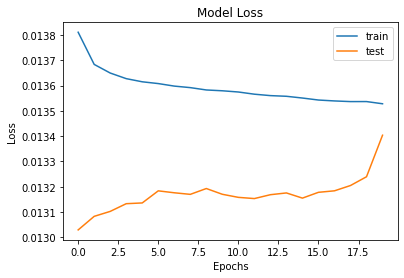

In [94]:
from matplotlib import pyplot
# plot history
plt.title('Model Loss')
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()


In [95]:
#Make Predictions
# create empty table with 40fields
#, 40)
train_predict1 = model1.predict(train_X)
train_predict1_dataset_like = np.zeros(shape=(len(train_predict1), 40))
# put the predicted values in the right field
train_predict1_dataset_like[:,0] = train_predict1[:,0]
# inverse transform and then select the right field
train_predict1 = scaler.inverse_transform(train_predict1_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict1[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict1[:])))



Train Mean Absolute Error: 23.733251422253055
Train Root Mean Squared Error: 26.603057772389953


In [96]:
test_predict1 = model1.predict(test_X)
test_predict1_dataset_like = np.zeros(shape=(len(test_predict1), 40))
# invert predictions
test_predict1_dataset_like[:,0] = test_predict1[:,0]
# inverse transform and then select the right field
test_predict1 = scaler.inverse_transform(test_predict1_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict1[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict1[:])))


Test Mean Absolute Error: 25.181500407212262
Test Root Mean Squared Error: 27.114655460198794


In [97]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

In [98]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [99]:
inv_yhat

array([24.675936, 24.61748 , 20.739979, ..., 26.678137, 28.120295,
       31.904398], dtype=float32)

In [100]:
np.amax(inv_yhat)

4101.987

In [101]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [102]:
inv_y

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [103]:
np.amax(inv_y)

249.99

In [104]:
np.average(inv_y)

21.535181

In [105]:
np.average(inv_yhat)

39.0601

In [106]:

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y, inv_yhat))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y, inv_yhat))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))
#print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.r2_score(inv_y, inv_yhat))

Mean Absolute Error (MAE): 28.824310
Mean Square Error (MSE): 6974.477051


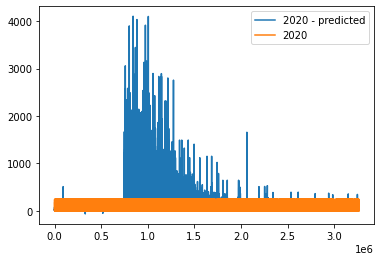

In [108]:
plt.plot(inv_yhat, label = '2020 - predicted')
plt.plot(inv_y, label = '2020')
plt.legend()
plt.show()

In [ ]:
#

In [43]:
#define fit model for 2019
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)


In [44]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model2 = Sequential()
model2.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dropout(0.15))
model2.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                18200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [45]:
filepath='weights_only_train2019_test2020_n50_b72'

checkpoint_dir = os.path.dirname(filepath)

callbacks_list = [EarlyStopping(monitor='mae', patience = 5),
                  ModelCheckpoint(filepath, monitor='mae', save_freq='epoch', save_weights_only=True)]


In [82]:
history2 = model2.fit(train_X, train_y, epochs=20,validation_data=(test_X, test_y), batch_size=64, shuffle=False,
                    callbacks=[callbacks_list])

Epoch 1/20
 8596/52633 [===>..........................] - ETA: 4:05 - loss: 0.0138 - mae: 0.0660

KeyboardInterrupt: 

In [80]:
model2.save('./210414_Model_50neuron_batch64_20epochs_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210414_Model_50neuron_batch64_20epochs_tf')

INFO:tensorflow:Assets written to: ./210414_Model_50neuron_batch64_20epochs_tf\assets


In [81]:
#

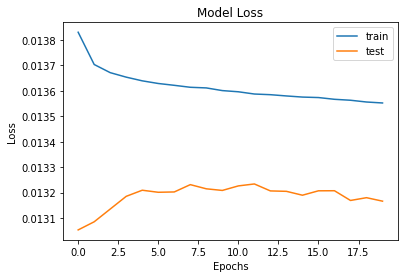

In [52]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

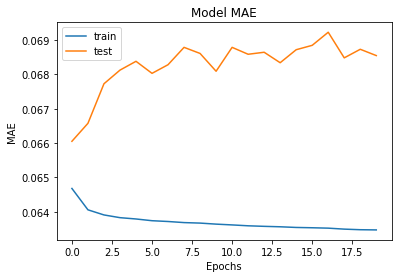

In [172]:
from matplotlib import pyplot
# plot history
plt.title('Model MAE')
pyplot.plot(history2.history['mae'], label='train')
pyplot.plot(history2.history['val_mae'], label='test')
plt.ylabel('MAE')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [55]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
#, 40)
train_predict2 = model2.predict(train_X)
train_predict2_dataset_like = np.zeros(shape=(len(train_predict2), 40))
# put the predicted values in the right field
train_predict2_dataset_like[:,0] = train_predict2[:,0]
# inverse transform and then select the right field
train_predict2 = scaler.inverse_transform(train_predict2_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict2[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict2[:])))

Train Mean Absolute Error: 23.663732832913798
Train Root Mean Squared Error: 26.529316890462635


In [56]:
test_predict2 = model2.predict(test_X)
test_predict2_dataset_like = np.zeros(shape=(len(test_predict2), 40))
# invert predictions
test_predict2_dataset_like[:,0] = test_predict2[:,0]
# inverse transform and then select the right field
test_predict2 = scaler.inverse_transform(test_predict2_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict2[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict2[:])))

Test Mean Absolute Error: 24.49746691052151
Test Root Mean Squared Error: 26.143892621151384


In [57]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat2 = model2.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat2 = concatenate((yhat2, test_X[:, 1:]), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat2)
inv_yhat2 = inv_yhat2[:,0]

In [58]:
inv_yhat2

array([22.0631  , 22.031132, 23.050306, ..., 25.575163, 25.97155 ,
       27.024643], dtype=float32)

In [209]:
np.amax(inv_yhat2)

179.24977

In [60]:
np.average(inv_yhat2)

24.583597

In [61]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y2 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y2 = scaler.inverse_transform(inv_y2)
inv_y2 = inv_y2[:,0]

In [62]:
inv_y2

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [63]:
np.amax(inv_y2)

249.99

In [64]:
np.average(inv_y2)

21.535181

In [65]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y2, inv_yhat2))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y2, inv_yhat2))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))
#print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.r2_score(inv_y, inv_yhat))

Mean Absolute Error (MAE): 17.135988
Mean Square Error (MSE): 822.840149


C:\Users\aschu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


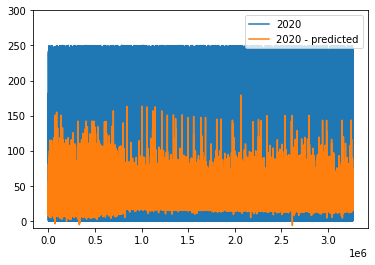

In [84]:
#import matplotlib as plt
from matplotlib import pyplot as plt
plt.plot(inv_y2, label = '2020')
plt.plot(inv_yhat2, label = '2020 - predicted')
plt.ylim([-10, 300])
plt.legend()
plt.show()

In [ ]:
#

In [73]:
#define fit model for 2019
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)


In [74]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# design network
model3 = Sequential()
model3.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model3.add(Dropout(0.15))
model3.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [75]:
filepath='weights_only_train2019_test2020_n50_b64_nocrossval'

checkpoint_dir = os.path.dirname(filepath)

callbacks_list = [EarlyStopping(monitor='mae', patience = 5),
                  ModelCheckpoint(filepath, monitor='mae', save_freq='epoch', save_weights_only=True)]

In [78]:
history3 = model3.fit(train_X, train_y, epochs=30, batch_size=64, shuffle=False,
                    callbacks=[callbacks_list])

Epoch 1/30
52633/52633 [==============================] - 295s 6ms/step - loss: 0.0138 - mae: 0.0645
Epoch 2/30
52633/52633 [==============================] - 290s 6ms/step - loss: 0.0137 - mae: 0.0640
Epoch 3/30
52633/52633 [==============================] - 294s 6ms/step - loss: 0.0137 - mae: 0.0639
Epoch 4/30
52633/52633 [==============================] - 291s 6ms/step - loss: 0.0137 - mae: 0.0638
Epoch 5/30
52633/52633 [==============================] - 289s 5ms/step - loss: 0.0136 - mae: 0.0638
Epoch 6/30
52633/52633 [==============================] - 291s 6ms/step - loss: 0.0136 - mae: 0.0637
Epoch 7/30
52633/52633 [==============================] - 289s 5ms/step - loss: 0.0136 - mae: 0.0637 0s - loss: 0.0136 -
Epoch 8/30
52633/52633 [==============================] - 293s 6ms/step - loss: 0.0136 - mae: 0.0636
Epoch 9/30
52633/52633 [==============================] - 296s 6ms/step - loss: 0.0136 - mae: 0.0636
Epoch 10/30
52633/52633 [==============================] - 292s 6ms/ste

In [79]:
model3.save('./210414_Model_50neuron_batch64_20epochs_nocrossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210414_Model_50neuron_batch64_20epochs_nocrossval_tf')

INFO:tensorflow:Assets written to: ./210414_Model_50neuron_batch64_20epochs_nocrossval_tf\assets


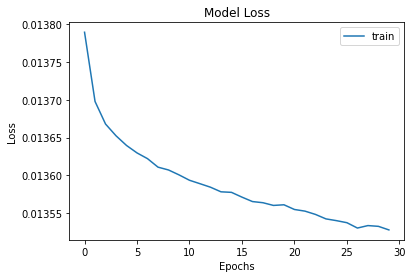

In [85]:
#import matplotlib as plt
from matplotlib import pyplot
# plot history
plt.title('Model Loss')
pyplot.plot(history3.history['loss'], label='train')
#pyplot.plot(history3.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()

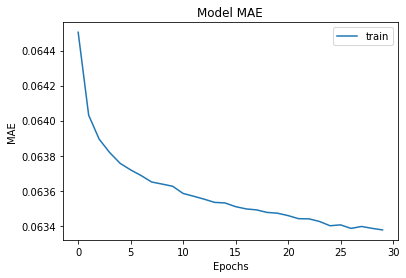

In [171]:
from matplotlib import pyplot
# plot history
plt.title('Model MAE')
pyplot.plot(history3.history['mae'], label='train')
#pyplot.plot(history3.history['val_loss'], label='test')
plt.ylabel('MAE')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [86]:
#Make Predictions
# create empty table with 40fields
train_predict3 = model3.predict(train_X)
train_predict3_dataset_like = np.zeros(shape=(len(train_predict3), 40))
# put the predicted values in the right field
train_predict3_dataset_like[:,0] = train_predict3[:,0]
# inverse transform and then select the right field
train_predict3 = scaler.inverse_transform(train_predict3_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict3[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict3[:])))

Train Mean Absolute Error: 23.4385922277271
Train Root Mean Squared Error: 26.270124956481038


In [87]:
test_predict3 = model3.predict(test_X)
test_predict3_dataset_like = np.zeros(shape=(len(test_predict3), 40))
# invert predictions
test_predict3_dataset_like[:,0] = test_predict3[:,0]
# inverse transform and then select the right field
test_predict3 = scaler.inverse_transform(test_predict3_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict3[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict3[:])))

Test Mean Absolute Error: 25.833041265644656
Test Root Mean Squared Error: 28.46527662492981


In [89]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat3 = model3.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat3 = concatenate((yhat3, test_X[:, 1:]), axis=1)
inv_yhat3 = scaler.inverse_transform(inv_yhat3)
inv_yhat3 = inv_yhat3[:,0]

In [90]:
inv_yhat3

array([23.330221, 23.295767, 21.236654, ..., 23.829733, 24.582527,
       26.095356], dtype=float32)

In [91]:
np.amax(inv_yhat3)

355.95358

In [92]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y3 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y3 = scaler.inverse_transform(inv_y3)
inv_y3 = inv_y3[:,0]

In [93]:
inv_y3

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [94]:
np.amax(inv_y3)

249.99

In [95]:
np.average(inv_y3)

21.535181

In [208]:
np.average(inv_yhat3)

25.919174

In [98]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y3, inv_yhat3))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y3, inv_yhat3))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))
#print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.r2_score(inv_y, inv_yhat))

Mean Absolute Error (MAE): 17.924648
Mean Square Error (MSE): 855.169861


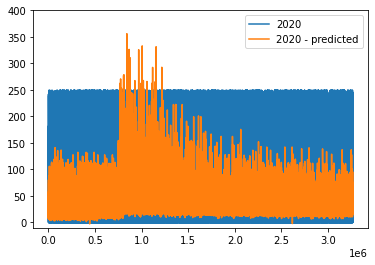

In [103]:
#import matplotlib as plt
from matplotlib import pyplot
plt.plot(inv_y3, label = '2020')
plt.plot(inv_yhat3, label = '2020 - predicted')
plt.ylim([-10, 400])
plt.legend()
plt.show()

In [ ]:
#

In [104]:
#define fit model for 2019
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)


In [105]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model4 = Sequential()
model4.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model4.add(Dropout(0.15))
model4.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model4.compile(loss='mse', optimizer='adam', metrics=['mae'])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [107]:
%load_ext tensorboard
#log_folder = 'logs'

import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [108]:
filepath='weights_only_train2019_test2020_n50_b32'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='mae', patience = 5),
                  ModelCheckpoint(filepath, monitor='mae', save_freq='epoch', save_weights_only=True), tensorboard_callback]

In [138]:
tensorboard --logdir=data/ --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 17400), started 2 days, 13:16:00 ago. (Use '!kill 17400' to kill it.)

In [110]:
history4 = model4.fit(train_X, train_y, epochs=30,validation_data=(test_X, test_y), batch_size=32, shuffle=False,
                    callbacks=callbacks_list)

Epoch 1/30
105266/105266 [==============================] - 760s 7ms/step - loss: 0.0142 - mae: 0.0662 - val_loss: 0.0130 - val_mae: 0.0658
Epoch 2/30
105266/105266 [==============================] - 770s 7ms/step - loss: 0.0140 - mae: 0.0651 - val_loss: 0.0131 - val_mae: 0.0653
Epoch 3/30
105266/105266 [==============================] - 806s 8ms/step - loss: 0.0140 - mae: 0.0650 - val_loss: 0.0131 - val_mae: 0.0666
Epoch 4/30
105266/105266 [==============================] - 774s 7ms/step - loss: 0.0139 - mae: 0.0649 - val_loss: 0.0131 - val_mae: 0.0675
Epoch 5/30
105266/105266 [==============================] - 822s 8ms/step - loss: 0.0139 - mae: 0.0648 - val_loss: 0.0132 - val_mae: 0.0681
Epoch 6/30
105266/105266 [==============================] - 810s 8ms/step - loss: 0.0139 - mae: 0.0648 - val_loss: 0.0132 - val_mae: 0.0685
Epoch 7/30
105266/105266 [==============================] - 781s 7ms/step - loss: 0.0139 - mae: 0.0648 - val_loss: 0.0132 - val_mae: 0.0691
Epoch 8/30
105266/10

In [111]:
model4.save('./210414_Model_50neuron_batch32_30epochs_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210414_Model_50neuron_batch32_30epochs_tf')

INFO:tensorflow:Assets written to: ./210414_Model_50neuron_batch32_30epochs_tf\assets


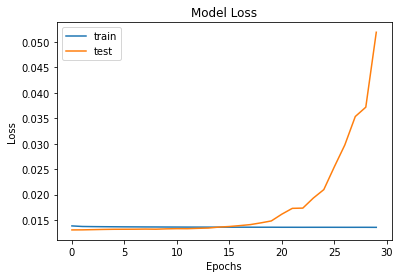

In [112]:
from matplotlib import pyplot
# plot history
plt.title('Model Loss')
pyplot.plot(history4.history['loss'], label='train')
pyplot.plot(history4.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()

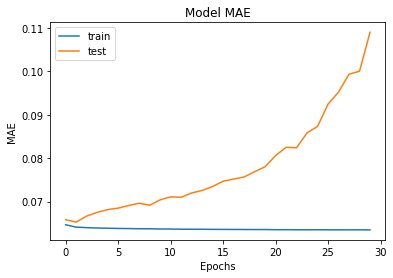

In [170]:
from matplotlib import pyplot
# plot history
plt.title('Model MAE')
pyplot.plot(history4.history['mae'], label='train')
pyplot.plot(history4.history['val_mae'], label='test')
plt.ylabel('MAE')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [114]:
#Make Predictions
# create empty table with 40fields
#, 40)
train_predict4 = model4.predict(train_X)
train_predict4_dataset_like = np.zeros(shape=(len(train_predict4), 40))
# put the predicted values in the right field
train_predict4_dataset_like[:,0] = train_predict4[:,0]
# inverse transform and then select the right field
train_predict4 = scaler.inverse_transform(train_predict4_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict4[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict4[:])))

Train Mean Absolute Error: 23.548654172227753
Train Root Mean Squared Error: 26.454471616319008


In [115]:
test_predict4 = model4.predict(test_X)
test_predict4_dataset_like = np.zeros(shape=(len(test_predict4), 40))
# invert predictions
test_predict4_dataset_like[:,0] = test_predict4[:,0]
# inverse transform and then select the right field
test_predict4 = scaler.inverse_transform(test_predict4_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict4[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict4[:])))

Test Mean Absolute Error: 37.47561422967973
Test Root Mean Squared Error: 62.85063866236094


In [116]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat4 = model4.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat4 = concatenate((yhat4, test_X[:, 1:]), axis=1)
inv_yhat4 = scaler.inverse_transform(inv_yhat4)
inv_yhat4 = inv_yhat4[:,0]



In [117]:
inv_yhat4

array([21.71483 , 21.665703, 20.375423, ..., 27.60051 , 28.61272 ,
       31.487675], dtype=float32)

In [118]:
np.amax(inv_yhat4)

2422.1672

In [119]:
np.average(inv_yhat4)

37.561703

In [120]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y4 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y4 = scaler.inverse_transform(inv_y4)
inv_y4 = inv_y4[:,0]

In [121]:
inv_y4

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [122]:
np.amax(inv_y4)

249.99

In [123]:
np.average(inv_y4)

21.535181

In [132]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y4, inv_yhat4))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y4,inv_yhat4))
print('R2 : %3f' % r2_score(inv_y4, inv_yhat4))

#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))


Mean Absolute Error (MAE): 27.258577
Mean Square Error (MSE): 3244.232178
R2 : -2.437745


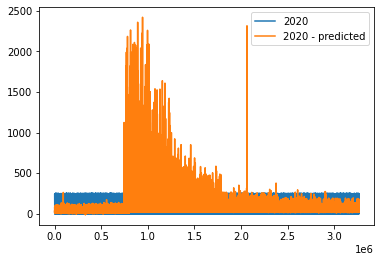

In [139]:
from matplotlib import pyplot
plt.plot(inv_y4, label = '2020')
plt.plot(inv_yhat4, label = '2020 - predicted')
plt.legend()
plt.show()

In [ ]:
#

In [173]:
#define fit model for 2019
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)


In [174]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model6 = Sequential()
model6.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model6.add(Dropout(0.15))
model6.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model6.compile(loss='mse', optimizer='adam', metrics=['mae'])
model6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [142]:
filepath='weights_only_train2019_test2020_n50_b16_30epochs'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='mae', patience = 5),
                  ModelCheckpoint(filepath, monitor='mae', save_freq='epoch', save_weights_only=True), tensorboard_callback]

In [143]:
%load_ext tensorboard
#log_folder = 'logs'

import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [144]:
history5 = model5.fit(train_X, train_y, epochs=30, batch_size=16, shuffle=False,
                    callbacks=callbacks_list)

Epoch 1/30
210531/210531 [==============================] - 1432s 7ms/step - loss: 0.0142 - mae: 0.0661
Epoch 2/30
210531/210531 [==============================] - 2212s 11ms/step - loss: 0.0140 - mae: 0.0652s - lo
Epoch 3/30
210531/210531 [==============================] - 2180s 10ms/step - loss: 0.0140 - mae: 0.0651
Epoch 4/30
210531/210531 [==============================] - 2245s 11ms/step - loss: 0.0140 - mae: 0.0650
Epoch 5/30
210531/210531 [==============================] - 2148s 10ms/step - loss: 0.0139 - mae: 0.0649
Epoch 6/30
210531/210531 [==============================] - 2190s 10ms/step - loss: 0.0139 - mae: 0.0649
Epoch 7/30
210531/210531 [==============================] - 2212s 11ms/step - loss: 0.0139 - mae: 0.0649
Epoch 8/30
210531/210531 [==============================] - 2271s 11ms/step - loss: 0.0139 - mae: 0.0648
Epoch 9/30
210531/210531 [==============================] - 2121s 10ms/step - loss: 0.0139 - mae: 0.0648
Epoch 10/30
210531/210531 [=======================

In [146]:
model5.load_weights(filepath)

In [148]:
model5.save('./210415_Model_50neuron_batch16_30epochs_nocrossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210414_Model_50neuron_batch32_30epochs_tf')

INFO:tensorflow:Assets written to: ./210415_Model_50neuron_batch16_30epochs_nocrossval_tf\assets


In [152]:
model5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


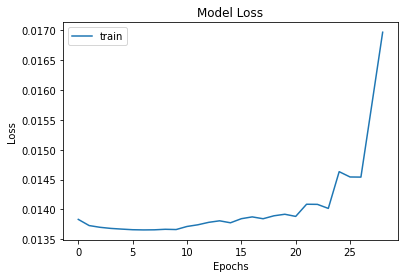

In [150]:
from matplotlib import pyplot
# plot history
plt.title('Model Loss')
pyplot.plot(history5.history['loss'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()


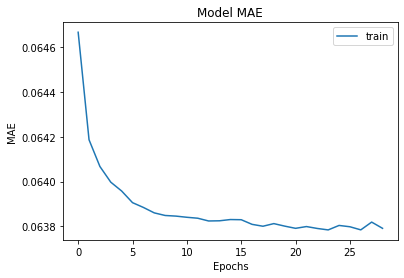

In [155]:
from matplotlib import pyplot
# plot history
plt.title('Model MAE')
pyplot.plot(history5.history['mae'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
plt.ylabel('MAE')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [153]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict5 = model5.predict(train_X)
train_predict5_dataset_like = np.zeros(shape=(len(train_predict5), 40))
# put the predicted values in the right field
train_predict5_dataset_like[:,0] = train_predict5[:,0]
# inverse transform and then select the right field
train_predict5 = scaler.inverse_transform(train_predict5_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict5[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict5[:])))

Train Mean Absolute Error: 23.578353416979635
Train Root Mean Squared Error: 29.21361685878619


In [156]:
test_predict5 = model5.predict(test_X)
test_predict5_dataset_like = np.zeros(shape=(len(test_predict5), 40))
# invert predictions
test_predict5_dataset_like[:,0] = test_predict5[:,0]
# inverse transform and then select the right field
test_predict5 = scaler.inverse_transform(test_predict5_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict5[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict5[:])))

Test Mean Absolute Error: 533.5847766713523
Test Root Mean Squared Error: 2137.922632759699


In [157]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat5 = model5.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat5 = concatenate((yhat5, test_X[:, 1:]), axis=1)
inv_yhat5 = scaler.inverse_transform(inv_yhat5)
inv_yhat5 = inv_yhat5[:,0]

In [158]:
inv_yhat5


array([24.909645, 24.858505, 20.01024 , ..., 70.57876 , 77.24303 ,
       89.140366], dtype=float32)

In [159]:
np.amax(inv_yhat5)

55813.816

In [160]:
np.average(inv_yhat5)

533.6709

In [161]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y5 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y5 = scaler.inverse_transform(inv_y5)
inv_y5 = inv_y5[:,0]

In [162]:
inv_y5

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [163]:
np.amax(inv_y5)

249.99

In [164]:
np.average(inv_yhat5)

533.6709

In [165]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y5, inv_yhat5))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y5, inv_yhat5))
print('R2 : %3f' % r2_score(inv_y5, inv_yhat5))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 519.099792
Mean Square Error (MSE): 4537129.000000
R2 : -4806.758575


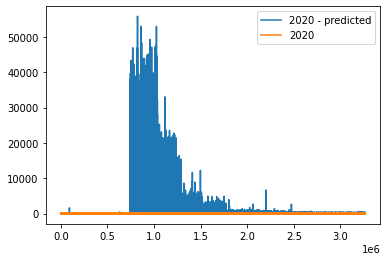

In [167]:

plt.plot(inv_yhat5, label = '2020 - predicted')
plt.plot(inv_y5, label = '2020')
plt.legend()
plt.show()

In [ ]:
#

In [183]:
#define fit model for 2019
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)


In [184]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model6 = Sequential()
model6.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model6.add(Dropout(0.15))
model6.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model6.compile(loss='mse', optimizer='adam', metrics=['mae'])
model6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [185]:
filepath='weights_only_train2019_test2020_n50_b16_epochs.epochs{epoch:02d}'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

In [186]:
%reload_ext tensorboard
#log_folder = 'logs'

In [46]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [181]:
tensorboard --logdir=data/ --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 17400), started 3 days, 12:08:38 ago. (Use '!kill 17400' to kill it.)

In [188]:
history6 = model6.fit(train_X, train_y, epochs=9, batch_size=16, shuffle=False,
                    callbacks=callbacks_list)

Epoch 1/9
210531/210531 [==============================] - 2378s 11ms/step - loss: 0.0142 - mae: 0.0662
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b16_epochs.epochs01\assets
Epoch 2/9
210531/210531 [==============================] - 2379s 11ms/step - loss: 0.0140 - mae: 0.0653
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b16_epochs.epochs02\assets
Epoch 3/9
210531/210531 [==============================] - 2394s 11ms/step - loss: 0.0140 - mae: 0.0651
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b16_epochs.epochs03\assets
Epoch 4/9
210531/210531 [==============================] - 2413s 11ms/step - loss: 0.0140 - mae: 0.0651
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b16_epochs.epochs04\assets
Epoch 5/9
210531/210531 [==============================] - 2391s 11ms/step - loss: 0.0139 - mae: 0.0650
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b16_epochs.epochs

In [214]:
model6.save('./210416_Model_50neuron_batch16_9epochs_tf', save_format='tf')

loaded_model = tf.keras.models.load_model('./210416_Model_50neuron_batch16_9epochs_tf')

INFO:tensorflow:Assets written to: ./210416_Model_50neuron_batch16_9epochs_tf\assets


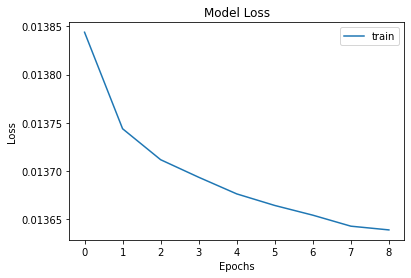

In [190]:
from matplotlib import pyplot
# plot history
plt.title('Model Loss')
pyplot.plot(history6.history['loss'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()


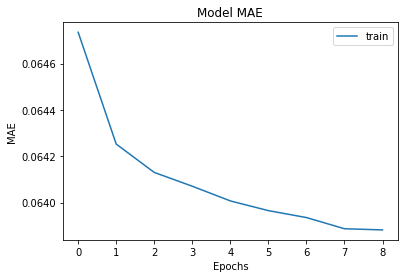

In [192]:
from matplotlib import pyplot
# plot history
plt.title('Model MAE')
pyplot.plot(history6.history['mae'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
plt.ylabel('MAE')
plt.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [193]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict6 = model6.predict(train_X)
train_predict6_dataset_like = np.zeros(shape=(len(train_predict6), 40))
# put the predicted values in the right field
train_predict6_dataset_like[:,0] = train_predict6[:,0]
# inverse transform and then select the right field
train_predict6 = scaler.inverse_transform(train_predict6_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict6[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict6[:])))

Train Mean Absolute Error: 23.409405972729306
Train Root Mean Squared Error: 26.392725808863503


In [195]:
test_predict6 = model6.predict(test_X)
test_predict6_dataset_like = np.zeros(shape=(len(test_predict6), 40))
# invert predictions
test_predict6_dataset_like[:,0] = test_predict6[:,0]
# inverse transform and then select the right field
test_predict6 = scaler.inverse_transform(test_predict6_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict6[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict6[:])))

Test Mean Absolute Error: 36.58774472210693
Test Root Mean Squared Error: 43.35771843665706


In [198]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat6 = model6.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat6 = concatenate((yhat6, test_X[:, 1:]), axis=1)
inv_yhat6 = scaler.inverse_transform(inv_yhat6)
inv_yhat6 = inv_yhat6[:,0]

In [199]:
inv_yhat6

array([22.41711 , 22.373728, 20.487633, ..., 32.494495, 34.383213,
       37.74751 ], dtype=float32)

In [200]:
np.amax(inv_yhat6)


812.19775

In [201]:

np.average(inv_yhat6)

36.6739

In [202]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y6 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y6 = scaler.inverse_transform(inv_y6)
inv_y6 = inv_y6[:,0]

In [203]:
inv_y6

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [204]:
np.amax(inv_y6)

249.99

In [205]:
np.average(inv_y6)

21.535181

In [206]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y6, inv_yhat6))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y6, inv_yhat6))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y6, inv_yhat6))
print('R2 : %3f' % r2_score(inv_y6, inv_yhat6))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))


Mean Absolute Error (MAE): 25.548115
Mean Square Error (MSE): 1304.495605
R2 : -0.382306


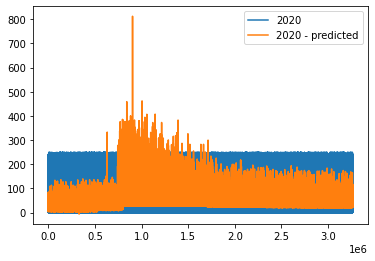

In [207]:
plt.plot(inv_y6, label = '2020')
plt.plot(inv_yhat6, label = '2020 - predicted')
plt.legend()
plt.show()

In [ ]:
#

In [40]:
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)


In [41]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model7 = Sequential()
model7.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model7.add(Dropout(0.15))
model7.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model7.compile(loss='mse', optimizer='adam', metrics=['mae'])
model7.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                18200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%load_ext tensorboard

In [47]:
filepath='weights_only_train2020_test2019_n50_b64'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

In [50]:
tensorboard --logdir=data/ --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 17400), started 4 days, 15:20:27 ago. (Use '!kill 17400' to kill it.)

In [52]:
history7 = model7.fit(train_X, train_y, epochs=20, batch_size=64, shuffle=False,
                    callbacks=callbacks_list)


Epoch 1/20
51021/51021 [==============================] - 324s 6ms/step - loss: 0.0128 - mae: 0.0612
Epoch 2/20
51021/51021 [==============================] - 313s 6ms/step - loss: 0.0128 - mae: 0.0612
Epoch 3/20
51021/51021 [==============================] - 331s 6ms/step - loss: 0.0128 - mae: 0.0612
Epoch 4/20
51021/51021 [==============================] - 327s 6ms/step - loss: 0.0128 - mae: 0.0611
Epoch 5/20
51021/51021 [==============================] - 324s 6ms/step - loss: 0.0128 - mae: 0.0611
Epoch 6/20
51021/51021 [==============================] - 312s 6ms/step - loss: 0.0128 - mae: 0.0611
Epoch 7/20
51021/51021 [==============================] - 297s 6ms/step - loss: 0.0128 - mae: 0.0611
Epoch 8/20
51021/51021 [==============================] - 318s 6ms/step - loss: 0.0128 - mae: 0.0611
Epoch 9/20
51021/51021 [==============================] - 332s 7ms/step - loss: 0.0128 - mae: 0.0611
Epoch 10/20
51021/51021 [==============================] - 325s 6ms/step - loss: 0.0128 - m

In [53]:
model7.save('./210417_Model_50neuron_batch64_20epochs_train2020_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210417_Model_50neuron_batch64_20epochs_train2020_tf')

INFO:tensorflow:Assets written to: ./210417_Model_50neuron_batch64_20epochs_train2020_tf\assets


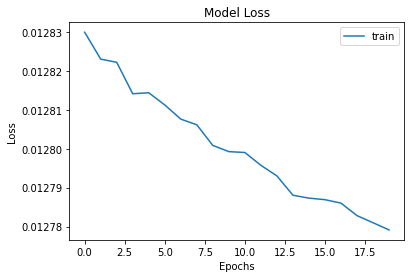

In [57]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history7.history['loss'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

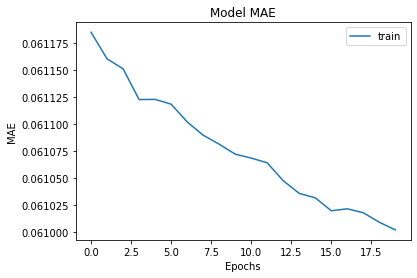

In [60]:
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history7.history['mae'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [62]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict7 = model7.predict(train_X)
train_predict7_dataset_like = np.zeros(shape=(len(train_predict7), 40))
# put the predicted values in the right field
train_predict7_dataset_like[:,0] = train_predict7[:,0]
# inverse transform and then select the right field
train_predict7 = scaler.inverse_transform(train_predict7_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict7[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict7[:])))

Train Mean Absolute Error: 23.693134041698386
Train Root Mean Squared Error: 27.478857429587897


In [63]:
test_predict7 = model7.predict(test_X)
test_predict7_dataset_like = np.zeros(shape=(len(test_predict7), 40))
# invert predictions
test_predict7_dataset_like[:,0] = test_predict7[:,0]
# inverse transform and then select the right field
test_predict7 = scaler.inverse_transform(test_predict7_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict7[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict7[:])))

Test Mean Absolute Error: 23.8460078918836
Test Root Mean Squared Error: 27.525616860166117


In [65]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat7 = model7.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat7 = concatenate((yhat7, test_X[:, 1:]), axis=1)
inv_yhat7 = scaler.inverse_transform(inv_yhat7)
inv_yhat7 = inv_yhat7[:,0]

In [66]:
inv_yhat7

array([18.957533, 11.30058 , 11.282603, ..., 28.472929, 43.18511 ,
       35.59726 ], dtype=float32)

In [67]:
np.amax(inv_yhat7)

305.57443

In [68]:
np.average(inv_yhat7)

23.933483

In [69]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y7 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y7 = scaler.inverse_transform(inv_y7)
inv_y7 = inv_y7[:,0]

In [70]:
inv_y7

array([ 0.15,  0.11,  0.23, ...,  9.2 , 13.14, 19.43], dtype=float32)

In [71]:
np.amax(inv_y7)

249.99

In [72]:
np.average(inv_y7)

21.897882

In [73]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y7, inv_yhat7))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y7, inv_yhat7))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y7, inv_yhat7))
print('R2 : %3f' % r2_score(inv_y7, inv_yhat7))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 16.861917
Mean Square Error (MSE): 859.137146
R2 : 0.146450


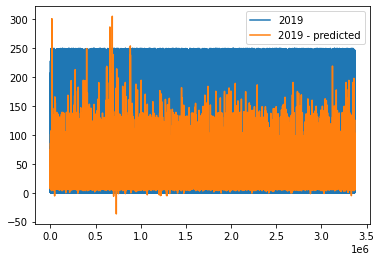

In [99]:
pyplot.plot(inv_y7, label = '2019')
pyplot.plot(inv_yhat7, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#

In [78]:
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)


In [79]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model8 = Sequential()
model8.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model8.add(Dropout(0.15))
model8.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model8.compile(loss='mse', optimizer='adam', metrics=['mae'])
model8.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [80]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [81]:
filepath='weights_only_train2020_test2019_n50_b32_epochs20'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

In [82]:

tensorboard --logdir=data/ --host localhost --port 8088


Reusing TensorBoard on port 8088 (pid 17400), started 4 days, 19:12:52 ago. (Use '!kill 17400' to kill it.)

In [83]:
history8 = model8.fit(train_X, train_y, epochs=20, batch_size=32, shuffle=False,
                    callbacks=callbacks_list)

Epoch 1/20
102041/102041 [==============================] - 649s 6ms/step - loss: 0.0137 - mae: 0.0643
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b32_epochs20\assets
Epoch 2/20
102041/102041 [==============================] - 652s 6ms/step - loss: 0.0135 - mae: 0.0633
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b32_epochs20\assets
Epoch 3/20
102041/102041 [==============================] - 646s 6ms/step - loss: 0.0134 - mae: 0.0631
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b32_epochs20\assets
Epoch 4/20
102041/102041 [==============================] - 660s 6ms/step - loss: 0.0134 - mae: 0.0631
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b32_epochs20\assets
Epoch 5/20
102041/102041 [==============================] - 627s 6ms/step - loss: 0.0134 - mae: 0.0630
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b32_epochs20\assets
Epoch 6/20
102041/102041 [====

In [84]:
model8.save('./210417_Model_50neuron_batch32_20epochs_train2020_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210417_Model_50neuron_batch32_20epochs_train2020_tf')

INFO:tensorflow:Assets written to: ./210417_Model_50neuron_batch32_20epochs_train2020_tf\assets


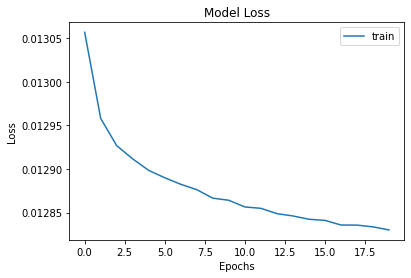

In [85]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history8.history['loss'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

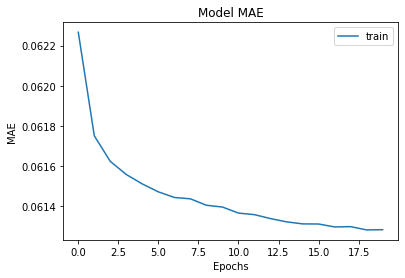

In [86]:
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history8.history['mae'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [87]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict8 = model8.predict(train_X)
train_predict8_dataset_like = np.zeros(shape=(len(train_predict8), 40))
# put the predicted values in the right field
train_predict8_dataset_like[:,0] = train_predict8[:,0]
# inverse transform and then select the right field
train_predict8 = scaler.inverse_transform(train_predict8_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict8[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict8[:])))


Train Mean Absolute Error: 24.198879658135436
Train Root Mean Squared Error: 28.068094037953024


In [88]:
test_predict8 = model8.predict(test_X)
test_predict8_dataset_like = np.zeros(shape=(len(test_predict8), 40))
# invert predictions
test_predict8_dataset_like[:,0] = test_predict8[:,0]
# inverse transform and then select the right field
test_predict8 = scaler.inverse_transform(test_predict8_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict8[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict8[:])))

Test Mean Absolute Error: 23.5073977137193
Test Root Mean Squared Error: 27.188433312479457


In [89]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat8 = model8.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat8 = concatenate((yhat8, test_X[:, 1:]), axis=1)
inv_yhat8 = scaler.inverse_transform(inv_yhat8)
inv_yhat8 = inv_yhat8[:,0]

In [90]:
inv_yhat8

array([19.489042, 10.14356 , 10.123648, ..., 37.918762, 45.00106 ,
       35.48729 ], dtype=float32)

In [91]:
np.amax(inv_yhat8)

187.06175

In [92]:
np.average(inv_yhat8)

23.59455

In [93]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y8 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y8 = scaler.inverse_transform(inv_y8)
inv_y8 = inv_y8[:,0]

In [94]:
inv_y8

array([ 0.15,  0.11,  0.23, ...,  9.2 , 13.14, 19.43], dtype=float32)

In [95]:
np.amax(inv_y8)

249.99

In [96]:
np.average(inv_y8)

21.897882

In [97]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y8, inv_yhat8))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y8, inv_yhat8))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y8, inv_yhat8))
print('R2 : %3f' % r2_score(inv_y8, inv_yhat8))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 16.832779
Mean Square Error (MSE): 860.746521
R2 : 0.144851


C:\Users\aschu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


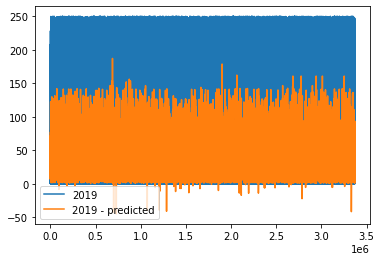

In [100]:
pyplot.plot(inv_y8, label = '2019')
pyplot.plot(inv_yhat8, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#

In [101]:
#define fit model for 2019
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)


In [102]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model9 = Sequential()
model9.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model9.add(Dropout(0.15))
model9.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model9.compile(loss='mse', optimizer='adam', metrics=['mae'])
model9.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [103]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2019_test2020_n50_b64_epochs20_nocrossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [105]:
tensorboard --logdir=data/ --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 17400), started 4 days, 22:54:43 ago. (Use '!kill 17400' to kill it.)

In [106]:
history9 = model9.fit(train_X, train_y, epochs=20, batch_size=64, shuffle=False,
                    callbacks=callbacks_list)

model9.save('./210417_Model_50neuron_batch64_20epochs_train2019_nocrossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210417_Model_50neuron_batch64_20epochs_train2020_tf')

Epoch 1/20
52633/52633 [==============================] - 326s 6ms/step - loss: 0.0142 - mae: 0.0663
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20_nocrossval\assets
Epoch 2/20
52633/52633 [==============================] - 321s 6ms/step - loss: 0.0140 - mae: 0.0651
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20_nocrossval\assets
Epoch 3/20
52633/52633 [==============================] - 319s 6ms/step - loss: 0.0139 - mae: 0.0649
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20_nocrossval\assets
Epoch 4/20
52633/52633 [==============================] - 316s 6ms/step - loss: 0.0139 - mae: 0.0648
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20_nocrossval\assets
Epoch 5/20
52633/52633 [==============================] - 319s 6ms/step - loss: 0.0139 - mae: 0.0647
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs20_noc

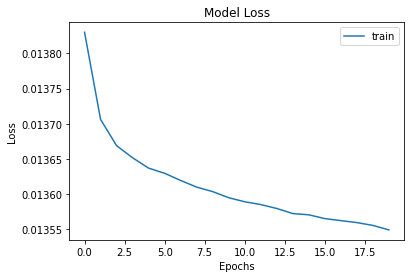

In [107]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history9.history['loss'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

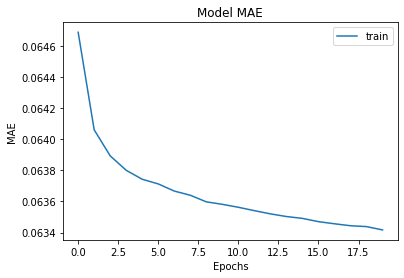

In [108]:
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history9.history['mae'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [109]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict9 = model9.predict(train_X)
train_predict9_dataset_like = np.zeros(shape=(len(train_predict9), 40))
# put the predicted values in the right field
train_predict9_dataset_like[:,0] = train_predict9[:,0]
# inverse transform and then select the right field
train_predict9 = scaler.inverse_transform(train_predict9_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict9[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict9[:])))

Train Mean Absolute Error: 23.61648702715323
Train Root Mean Squared Error: 26.41933590571412


In [110]:
test_predict9 = model9.predict(test_X)
test_predict9_dataset_like = np.zeros(shape=(len(test_predict9), 40))
# invert predictions
test_predict9_dataset_like[:,0] = test_predict9[:,0]
# inverse transform and then select the right field
test_predict9 = scaler.inverse_transform(test_predict9_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict9[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict9[:])))

Test Mean Absolute Error: 24.67443232306183
Test Root Mean Squared Error: 26.424748106119054


In [111]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat9= model9.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat9= concatenate((yhat9, test_X[:, 1:]), axis=1)
inv_yhat9= scaler.inverse_transform(inv_yhat9)
inv_yhat9= inv_yhat9[:,0]

In [112]:
inv_yhat9

array([23.20378 , 23.166203, 20.735384, ..., 23.844284, 24.911957,
       26.964643], dtype=float32)

In [113]:
np.amax(inv_yhat9)

238.8379

In [114]:
np.average(inv_yhat9)

24.760544

In [115]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y9 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y9 = scaler.inverse_transform(inv_y9)
inv_y9 = inv_y9[:,0]

In [116]:
inv_y9

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [117]:
np.amax(inv_y9)

249.99

In [118]:
np.average(inv_y9)

21.535181

In [119]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y9, inv_yhat9))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y9, inv_yhat9))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y9, inv_yhat9))
print('R2 : %3f' % r2_score(inv_y9, inv_yhat9))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 17.241936
Mean Square Error (MSE): 826.207764
R2 : 0.124511


C:\Users\aschu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


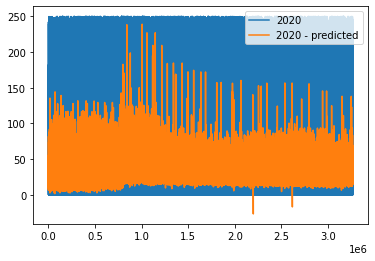

In [120]:
pyplot.plot(inv_y9, label = '2020')
pyplot.plot(inv_yhat9, label = '2020 - predicted')
pyplot.legend()
pyplot.show()

In [121]:
#

In [122]:
#Train 2019
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model10 = Sequential()
model10.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model10.add(Dropout(0.15))
model10.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model10.compile(loss='mse', optimizer='adam', metrics=['mae'])
model10.summary()

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [124]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2019_test2020_n50_b32_epochs20_nocrossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
#tensorboard --logdir=data/ --host localhost --port 8088

In [125]:
history10 = model10.fit(train_X, train_y, epochs=20, batch_size=32, shuffle=False,
                    callbacks=callbacks_list)

model10.save('./210417_Model_50neuron_batch32_20epochs_train2019_nocrossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210417_Model_50neuron_batch64_20epochs_train2020_tf')

Epoch 1/20
105266/105266 [==============================] - 592s 6ms/step - loss: 0.0142 - mae: 0.0662
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b32_epochs20_nocrossval\assets
Epoch 2/20
105266/105266 [==============================] - 585s 6ms/step - loss: 0.0140 - mae: 0.0651
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b32_epochs20_nocrossval\assets
Epoch 3/20
105266/105266 [==============================] - 573s 5ms/step - loss: 0.0140 - mae: 0.0650
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b32_epochs20_nocrossval\assets
Epoch 4/20
105266/105266 [==============================] - 571s 5ms/step - loss: 0.0139 - mae: 0.0649
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b32_epochs20_nocrossval\assets
Epoch 5/20
105266/105266 [==============================] - 571s 5ms/step - loss: 0.0139 - mae: 0.0648
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b32_ep

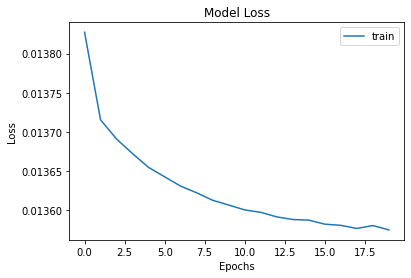

In [126]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history10.history['loss'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

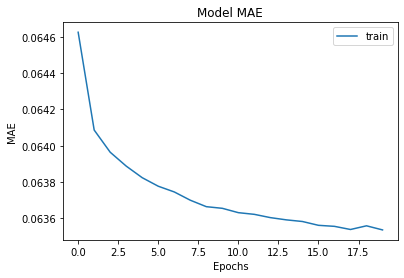

In [127]:
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history10.history['mae'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [128]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict10 = model10.predict(train_X)
train_predict10_dataset_like = np.zeros(shape=(len(train_predict10), 40))
# put the predicted values in the right field
train_predict10_dataset_like[:,0] = train_predict10[:,0]
# inverse transform and then select the right field
train_predict10 = scaler.inverse_transform(train_predict10_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict10[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict10[:])))

Train Mean Absolute Error: 23.538991304611116
Train Root Mean Squared Error: 26.403943057907526


In [129]:
test_predict10 = model10.predict(test_X)
test_predict10_dataset_like = np.zeros(shape=(len(test_predict10), 40))
# invert predictions
test_predict10_dataset_like[:,0] = test_predict10[:,0]
# inverse transform and then select the right field
test_predict10 = scaler.inverse_transform(test_predict10_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict10[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict10[:])))

Test Mean Absolute Error: 29.098347115267305
Test Root Mean Squared Error: 34.742716251598644


In [130]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat10= model10.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat10= concatenate((yhat10, test_X[:, 1:]), axis=1)
inv_yhat10= scaler.inverse_transform(inv_yhat10)
inv_yhat10= inv_yhat10[:,0]

In [131]:
inv_yhat10

array([21.578897, 21.545961, 20.605011, ..., 25.904207, 26.856113,
       29.076782], dtype=float32)

In [132]:
np.amax(inv_yhat10)

1512.5084

In [133]:
np.average(inv_yhat10)

29.184404

In [134]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y10 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y10 = scaler.inverse_transform(inv_y10)
inv_y10 = inv_y10[:,0]

In [135]:
inv_y10

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [136]:
np.amax(inv_y10)

249.99

In [137]:
np.average(inv_y10)

21.535181

In [138]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y10, inv_yhat10))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y10, inv_yhat10))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y10, inv_yhat10))
print('R2 : %3f' % r2_score(inv_y10, inv_yhat10))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 20.110096
Mean Square Error (MSE): 1043.515381
R2 : -0.105758


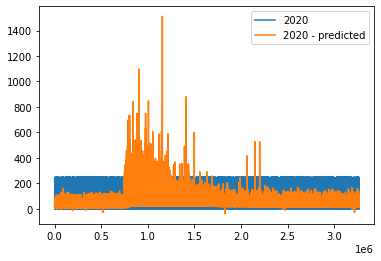

In [139]:
pyplot.plot(inv_y10, label = '2020')
pyplot.plot(inv_yhat10, label = '2020 - predicted')
pyplot.legend()
pyplot.show()

In [140]:
#

In [141]:
#Train 2019
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model11 = Sequential()
model11.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model11.add(Dropout(0.15))
model11.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model11.compile(loss='mse', optimizer='adam', metrics=['mae'])
model11.summary()

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [142]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2019_test2020_n50_b32_epochs30_nocrossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [143]:
history11 = model11.fit(train_X, train_y, epochs=30, batch_size=32, shuffle=False,
                    callbacks=callbacks_list)

model11.save('./210417_Model_50neuron_batch32_30epochs_train2019_nocrossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210417_Model_50neuron_batch64_30epochs_train2020_tf')

Epoch 1/30
105266/105266 [==============================] - 657s 6ms/step - loss: 0.0142 - mae: 0.0662
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b32_epochs30_nocrossval\assets
Epoch 2/30
105266/105266 [==============================] - 652s 6ms/step - loss: 0.0140 - mae: 0.0652
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b32_epochs30_nocrossval\assets
Epoch 3/30
105266/105266 [==============================] - 641s 6ms/step - loss: 0.0140 - mae: 0.0651
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b32_epochs30_nocrossval\assets
Epoch 4/30
105266/105266 [==============================] - 641s 6ms/step - loss: 0.0140 - mae: 0.0650
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b32_epochs30_nocrossval\assets
Epoch 5/30
105266/105266 [==============================] - 647s 6ms/step - loss: 0.0139 - mae: 0.0649
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b32_ep

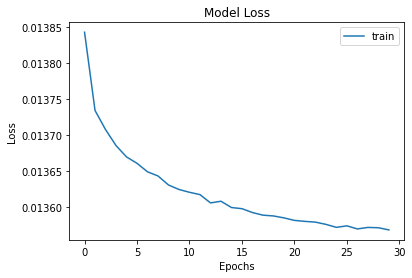

In [144]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history11.history['loss'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

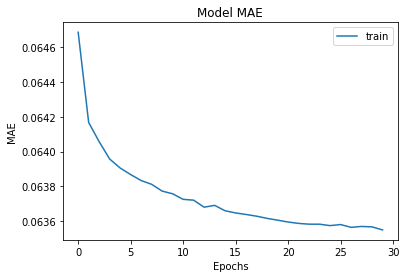

In [145]:
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history11.history['mae'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [146]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict11 = model11.predict(train_X)
train_predict11_dataset_like = np.zeros(shape=(len(train_predict11), 40))
# put the predicted values in the right field
train_predict11_dataset_like[:,0] = train_predict11[:,0]
# inverse transform and then select the right field
train_predict11 = scaler.inverse_transform(train_predict11_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict11[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict11[:])))

Train Mean Absolute Error: 23.539112308477826
Train Root Mean Squared Error: 26.370279404948867


In [147]:
test_predict11 = model11.predict(test_X)
test_predict11_dataset_like = np.zeros(shape=(len(test_predict11), 40))
# invert predictions
test_predict11_dataset_like[:,0] = test_predict11[:,0]
# inverse transform and then select the right field
test_predict11 = scaler.inverse_transform(test_predict11_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict11[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict11[:])))

Test Mean Absolute Error: 39.795803988140726
Test Root Mean Squared Error: 70.25581863716401


In [148]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat11= model11.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat11= concatenate((yhat11, test_X[:, 1:]), axis=1)
inv_yhat11= scaler.inverse_transform(inv_yhat11)
inv_yhat11= inv_yhat11[:,0]

In [149]:
inv_yhat11

array([23.750679, 23.710526, 21.111502, ..., 27.52521 , 28.483925,
       30.998482], dtype=float32)

In [150]:
np.amax(inv_yhat11)


2748.0273

In [151]:
np.average(inv_yhat11)

39.881878

In [152]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y11 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y11 = scaler.inverse_transform(inv_y11)
inv_y11 = inv_y11[:,0]

In [153]:
inv_y11

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [154]:
np.amax(inv_y11)



249.99

In [155]:
np.average(inv_y11)

21.535181

In [156]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y11, inv_yhat11))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y11, inv_yhat11))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y11, inv_yhat11))
print('R2 : %3f' % r2_score(inv_y11, inv_yhat11))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 29.218672
Mean Square Error (MSE): 4113.056641
R2 : -3.358390


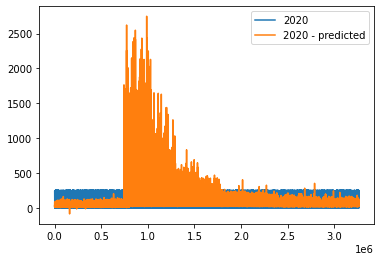

In [157]:
pyplot.plot(inv_y11, label = '2020')
pyplot.plot(inv_yhat11, label = '2020 - predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#

In [158]:
#Train 2019
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model12 = Sequential()
model12.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model12.add(Dropout(0.15))
model12.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model12.compile(loss='mse', optimizer='adam', metrics=['mae'])
model12.summary()

(3368492, 1, 40) (3368492,) (3265292, 1, 40) (3265292,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [159]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2019_test2020_n50_b64_epochs30_crossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [161]:
history12 = model12.fit(train_X, train_y, epochs=30, batch_size=64, validation_data=(test_X, test_y), shuffle=False,
                    callbacks=callbacks_list)

model12.save('./210418_Model_50neuron_batch64_30epochs_train2019_crossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210418_Model_50neuron_batch64_30epochs_train2019_tf')

Epoch 1/30
52633/52633 [==============================] - 433s 8ms/step - loss: 0.0138 - mae: 0.0644 - val_loss: 0.0130 - val_mae: 0.0663
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs30_crossval\assets
Epoch 2/30
52633/52633 [==============================] - 443s 8ms/step - loss: 0.0137 - mae: 0.0640 - val_loss: 0.0131 - val_mae: 0.0671
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs30_crossval\assets
Epoch 3/30
52633/52633 [==============================] - 435s 8ms/step - loss: 0.0137 - mae: 0.0639 - val_loss: 0.0131 - val_mae: 0.0670
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs30_crossval\assets
Epoch 4/30
52633/52633 [==============================] - 435s 8ms/step - loss: 0.0137 - mae: 0.0638 - val_loss: 0.0132 - val_mae: 0.0679
INFO:tensorflow:Assets written to: weights_only_train2019_test2020_n50_b64_epochs30_crossval\assets
Epoch 5/30
52633/52633 [========================

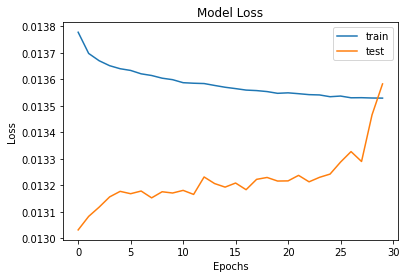

In [162]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history12.history['loss'], label='train')
pyplot.plot(history12.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

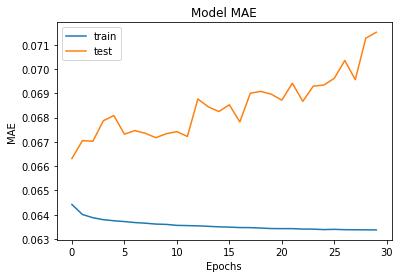

In [163]:
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history12.history['mae'], label='train')
pyplot.plot(history12.history['val_mae'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [164]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict12 = model12.predict(train_X)
train_predict12_dataset_like = np.zeros(shape=(len(train_predict12), 40))
# put the predicted values in the right field
train_predict12_dataset_like[:,0] = train_predict12[:,0]
# inverse transform and then select the right field
train_predict12 = scaler.inverse_transform(train_predict12_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict12[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict12[:])))

Train Mean Absolute Error: 23.70297594751674
Train Root Mean Squared Error: 26.56271139470036


In [165]:
test_predict12 = model12.predict(test_X)
test_predict12_dataset_like = np.zeros(shape=(len(test_predict12), 40))
# invert predictions
test_predict12_dataset_like[:,0] = test_predict12[:,0]
# inverse transform and then select the right field
test_predict12 = scaler.inverse_transform(test_predict12_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict12[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict12[:])))

Test Mean Absolute Error: 25.73545053949484
Test Root Mean Squared Error: 28.222441346144134


In [166]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat12= model12.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat12= concatenate((yhat12, test_X[:, 1:]), axis=1)
inv_yhat12= scaler.inverse_transform(inv_yhat12)
inv_yhat12= inv_yhat12[:,0]

In [167]:
inv_yhat12

array([22.58298 , 22.552212, 20.39679 , ..., 24.895432, 25.754755,
       27.364927], dtype=float32)

In [168]:
np.amax(inv_yhat12)

596.8531

In [169]:
np.average(inv_yhat12)

25.821512

In [170]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y12 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y12 = scaler.inverse_transform(inv_y12)
inv_y12 = inv_y12[:,0]

In [171]:
inv_y12

array([19.28, 16.52, 35.27, ..., 17.98, 23.59,  8.06], dtype=float32)

In [172]:
np.amax(inv_y12)

249.99

In [173]:
np.average(inv_y12)

21.535181

In [174]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y12, inv_yhat12))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y12, inv_yhat12))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y12, inv_yhat12))
print('R2 : %3f' % r2_score(inv_y12, inv_yhat12))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 17.877457
Mean Square Error (MSE): 848.813049
R2 : 0.100557


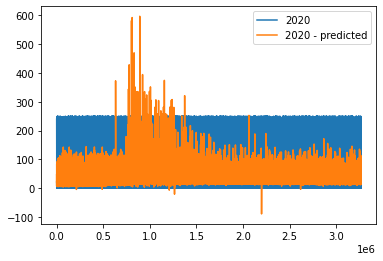

In [175]:
pyplot.plot(inv_y12, label = '2020')
pyplot.plot(inv_yhat12, label = '2020 - predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#

In [41]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model13 = Sequential()
model13.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model13.add(Dropout(0.15))
model13.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model13.compile(loss='mse', optimizer='adam', metrics=['mae'])
model13.summary()

(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                18200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [42]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train20209_test2019_n50_b64_epochs30_nocrossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

In [43]:
#tensorboard --logdir=data/ --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 17400), started 7 days, 16:00:40 ago. (Use '!kill 17400' to kill it.)

In [44]:
history13 = model13.fit(train_X, train_y, epochs=30, batch_size=64, shuffle=False,
                    callbacks=callbacks_list)

model13.save('./210420_Model_50neuron_batch64_30epochs_train2020_nocrossval_tf', save_format='tf')

Epoch 1/30
51021/51021 [==============================] - 285s 6ms/step - loss: 0.0137 - mae: 0.0643
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b64_epochs30_nocrossval\assets
Epoch 2/30
51021/51021 [==============================] - 276s 5ms/step - loss: 0.0134 - mae: 0.0632
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b64_epochs30_nocrossval\assets
Epoch 3/30
51021/51021 [==============================] - 285s 6ms/step - loss: 0.0134 - mae: 0.0630
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b64_epochs30_nocrossval\assets
Epoch 4/30
51021/51021 [==============================] - 290s 6ms/step - loss: 0.0134 - mae: 0.0630
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b64_epochs30_nocrossval\assets
Epoch 5/30
51021/51021 [==============================] - 292s 6ms/step - loss: 0.0134 - mae: 0.0629
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b64_epochs3

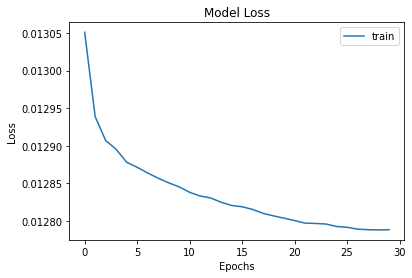

In [45]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history13.history['loss'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

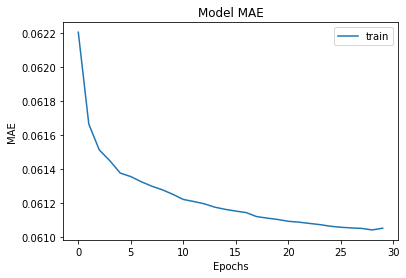

In [46]:
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history13.history['mae'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [47]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict13 = model13.predict(train_X)
train_predict13_dataset_like = np.zeros(shape=(len(train_predict13), 40))
# put the predicted values in the right field
train_predict13_dataset_like[:,0] = train_predict13[:,0]
# inverse transform and then select the right field
train_predict13 = scaler.inverse_transform(train_predict13_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict13[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict13[:])))

Train Mean Absolute Error: 24.336416644664432
Train Root Mean Squared Error: 27.922874949930858


In [48]:
test_predict13 = model13.predict(test_X)
test_predict13_dataset_like = np.zeros(shape=(len(test_predict13), 40))
# invert predictions
test_predict13_dataset_like[:,0] = test_predict13[:,0]
# inverse transform and then select the right field
test_predict13 = scaler.inverse_transform(test_predict13_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict13[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict13[:])))

Test Mean Absolute Error: 24.281122940813336
Test Root Mean Squared Error: 27.76003274957377


In [49]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat13= model13.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat13= concatenate((yhat13, test_X[:, 1:]), axis=1)
inv_yhat13= scaler.inverse_transform(inv_yhat13)
inv_yhat13= inv_yhat13[:,0]

In [50]:
inv_yhat13

array([19.727087, 11.154282, 11.136728, ..., 30.263615, 39.245632,
       37.154194], dtype=float32)

In [51]:
np.amax(inv_yhat13)

196.84639

In [52]:
np.average(inv_yhat13)

24.36852

In [53]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y13 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y13 = scaler.inverse_transform(inv_y13)
inv_y13 = inv_y13[:,0]

In [54]:
inv_y13

array([ 0.15,  0.11,  0.23, ...,  9.2 , 13.14, 19.43], dtype=float32)

In [55]:
np.amax(inv_y13)

249.99

In [56]:
np.average(inv_y13)

21.897882

In [57]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y13, inv_yhat13))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y13, inv_yhat13))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y13, inv_yhat13))
print('R2 : %3f' % r2_score(inv_y13, inv_yhat13))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 17.149147
Mean Square Error (MSE): 860.399902
R2 : 0.145196


C:\Users\aschu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


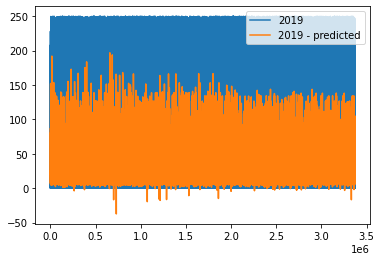

In [58]:
pyplot.plot(inv_y13, label = '2019')
pyplot.plot(inv_yhat13, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#

In [59]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model14 = Sequential()
model14.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model14.add(Dropout(0.15))
model14.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model14.compile(loss='mse', optimizer='adam', metrics=['mae'])
model14.summary()

(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [60]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train20209_test2019_n50_b32_epochs30_nocrossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [61]:
history14 = model14.fit(train_X, train_y, epochs=30, batch_size=32, shuffle=False,
                    callbacks=callbacks_list)

model14.save('./210420_Model_50neuron_batch32_30epochs_train2020_nocrossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210420_Model_50neuron_batch32_30epochs_train2020_nocrossval_tf')

Epoch 1/30
102041/102041 [==============================] - 567s 6ms/step - loss: 0.0137 - mae: 0.0642
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b32_epochs30_nocrossval\assets
Epoch 2/30
102041/102041 [==============================] - 572s 6ms/step - loss: 0.0135 - mae: 0.0632
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b32_epochs30_nocrossval\assets
Epoch 3/30
102041/102041 [==============================] - 567s 6ms/step - loss: 0.0134 - mae: 0.0631
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b32_epochs30_nocrossval\assets
Epoch 4/30
102041/102041 [==============================] - 517s 5ms/step - loss: 0.0134 - mae: 0.0630
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b32_epochs30_nocrossval\assets
Epoch 5/30
102041/102041 [==============================] - 535s 5ms/step - loss: 0.0134 - mae: 0.0630
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b

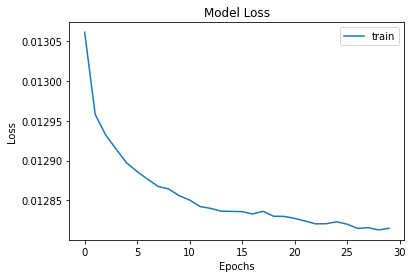

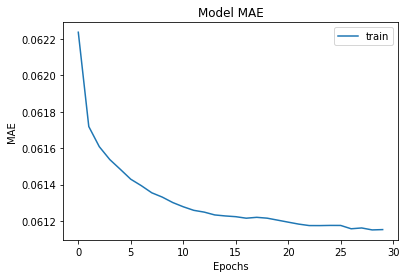

In [62]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history14.history['loss'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

print("\n")
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history14.history['mae'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [63]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict14 = model14.predict(train_X)
train_predict14_dataset_like = np.zeros(shape=(len(train_predict14), 40))
# put the predicted values in the right field
train_predict14_dataset_like[:,0] = train_predict14[:,0]
# inverse transform and then select the right field
train_predict14 = scaler.inverse_transform(train_predict14_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict14[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict14[:])))

print("\n")

test_predict14 = model14.predict(test_X)
test_predict14_dataset_like = np.zeros(shape=(len(test_predict14), 40))
# invert predictions
test_predict14_dataset_like[:,0] = test_predict14[:,0]
# inverse transform and then select the right field
test_predict14 = scaler.inverse_transform(test_predict14_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict14[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict14[:])))

Train Mean Absolute Error: 24.893688002453406
Train Root Mean Squared Error: 30.11557661602118


Test Mean Absolute Error: 23.169753855519655
Test Root Mean Squared Error: 26.73706486319575


In [64]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat14= model14.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat14= concatenate((yhat14, test_X[:, 1:]), axis=1)
inv_yhat14= scaler.inverse_transform(inv_yhat14)
inv_yhat14= inv_yhat14[:,0]

print("Predicted Metric Tons")
print(inv_yhat14)
print("\n")
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat14))
print("\n")
print("Predicted Average")
print(np.average(inv_yhat14))

Predicted Metric Tons
[17.547386   8.8650875  8.843758  ... 30.629974  35.968506  35.89915  ]


Predicted Max Metric Tons
358.91794


Predicted Average
23.255018


In [65]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y14 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y14 = scaler.inverse_transform(inv_y14)
inv_y14 = inv_y14[:,0]

print("Actual Metric Tons")
print(inv_y14)
print("\n")
print("Actual Max Metric Tons")
print(np.amax(inv_y14))
print("\n")
print("Actual Average Metric Tons")
print(np.average(inv_y14))

Actual Metric Tons
[ 0.15  0.11  0.23 ...  9.2  13.14 19.43]


Actual Max Metric Tons
249.99


Actual Average Metric Tons
21.897882


In [66]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y14, inv_yhat14))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y14, inv_yhat14))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y14, inv_yhat14))
print('R2 : %3f' % r2_score(inv_y14, inv_yhat14))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))


Mean Absolute Error (MAE): 16.612974
Mean Square Error (MSE): 856.137329
R2 : 0.149431


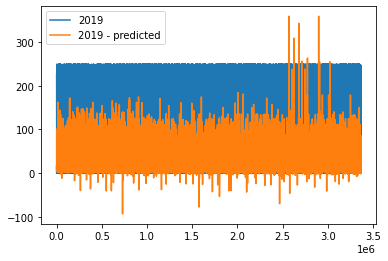

In [67]:
pyplot.plot(inv_y14, label = '2019')
pyplot.plot(inv_yhat14, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [68]:
#

In [69]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model15 = Sequential()
model15.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model15.add(Dropout(0.15))
model15.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model15.compile(loss='mse', optimizer='adam', metrics=['mae'])
model15.summary()

(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [70]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train20209_test2019_n50_b32_epochs30_nocrossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [71]:
history15 = model15.fit(train_X, train_y, epochs=30, batch_size=32, shuffle=False,
                    callbacks=callbacks_list)

model15.save('./210420_Model_50neuron_batch16_20epochs_train2020_nocrossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210420_Model_50neuron_batch16_20epochs_train2020_nocrossval_tf')

Epoch 1/30
102041/102041 [==============================] - 653s 6ms/step - loss: 0.0137 - mae: 0.0642
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b32_epochs30_nocrossval\assets
Epoch 2/30
102041/102041 [==============================] - 631s 6ms/step - loss: 0.0135 - mae: 0.0633
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b32_epochs30_nocrossval\assets
Epoch 3/30
102041/102041 [==============================] - 648s 6ms/step - loss: 0.0134 - mae: 0.0631
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b32_epochs30_nocrossval\assets
Epoch 4/30
102041/102041 [==============================] - 653s 6ms/step - loss: 0.0134 - mae: 0.0630
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b32_epochs30_nocrossval\assets
Epoch 5/30
102041/102041 [==============================] - 597s 6ms/step - loss: 0.0134 - mae: 0.0630
INFO:tensorflow:Assets written to: weights_only_train20209_test2019_n50_b

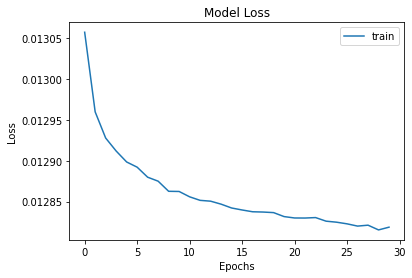

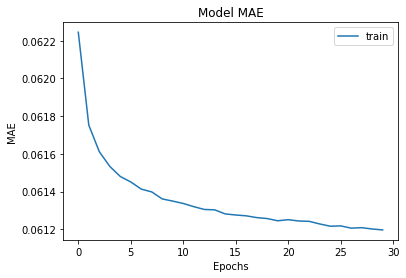

In [72]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history15.history['loss'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

print("\n")
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history15.history['mae'], label='train')
#pyplot.plot(history1.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [73]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict15 = model15.predict(train_X)
train_predict15_dataset_like = np.zeros(shape=(len(train_predict15), 40))
# put the predicted values in the right field
train_predict15_dataset_like[:,0] = train_predict15[:,0]
# inverse transform and then select the right field
train_predict15 = scaler.inverse_transform(train_predict15_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict15[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict15[:])))

print("\n")

test_predict15 = model15.predict(test_X)
test_predict15_dataset_like = np.zeros(shape=(len(test_predict15), 40))
# invert predictions
test_predict15_dataset_like[:,0] = test_predict15[:,0]
# inverse transform and then select the right field
test_predict15 = scaler.inverse_transform(test_predict15_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict15[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict15[:])))

Train Mean Absolute Error: 25.541133479818665
Train Root Mean Squared Error: 30.00232181082482


Test Mean Absolute Error: 24.410363196986673
Test Root Mean Squared Error: 27.9933890985201


In [74]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat15= model15.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat15= concatenate((yhat15, test_X[:, 1:]), axis=1)
inv_yhat15= scaler.inverse_transform(inv_yhat15)
inv_yhat15= inv_yhat15[:,0]

print("Predicted Metric Tons")
print(inv_yhat15)
print("\n")
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat15))
print("\n")
print("Predicted Average Metric Tons")
print(np.average(inv_yhat15))

Predicted Metric Tons
[19.380356 11.866218 11.847496 ... 34.07826  46.650543 35.04194 ]


Predicted Max Metric Tons
173.50258


Predicted Average Metric Tons
24.497932


In [75]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y15 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y15 = scaler.inverse_transform(inv_y15)
inv_y15 = inv_y15[:,0]

print("Actual Metric Tons")
print(inv_y15)
print("\n")
print("Actual Max Metric Tons")
print(np.amax(inv_y15))
print("\n")
print("Actual Average Metric Tons")
print(np.average(inv_y15))

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y15, inv_yhat15))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y15, inv_yhat15))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y15, inv_yhat15))
print('R2 : %3f' % r2_score(inv_y15, inv_yhat15))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Actual Metric Tons
[ 0.15  0.11  0.23 ...  9.2  13.14 19.43]


Actual Max Metric Tons
249.99


Actual Average Metric Tons
21.897882
Mean Absolute Error (MAE): 17.234119
Mean Square Error (MSE): 863.903015
R2 : 0.141715


C:\Users\aschu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


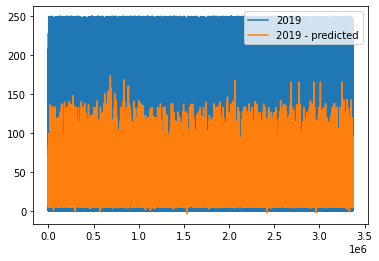

In [76]:
pyplot.plot(inv_y15, label = '2019')
pyplot.plot(inv_yhat15, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#

In [77]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model16 = Sequential()
model16.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model16.add(Dropout(0.15))
model16.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model16.compile(loss='mse', optimizer='adam', metrics=['mae'])
model16.summary()

(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [78]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2020_test2019_n50_b64_epochs20_crossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [81]:
history16 = model16.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), shuffle=False,
                    callbacks=callbacks_list)
model16.save('./210420_Model_50neuron_batch64_20epochs_train2020_crossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210420_Model_50neuron_batch64_20epochs_train2020_crossval_tf')

Epoch 1/20
51021/51021 [==============================] - 412s 8ms/step - loss: 0.0137 - mae: 0.0643 - val_loss: 0.0143 - val_mae: 0.0744
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs20_crossval\assets
Epoch 2/20
51021/51021 [==============================] - 418s 8ms/step - loss: 0.0134 - mae: 0.0632 - val_loss: 0.0140 - val_mae: 0.0712
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs20_crossval\assets
Epoch 3/20
51021/51021 [==============================] - 423s 8ms/step - loss: 0.0134 - mae: 0.0630 - val_loss: 0.0140 - val_mae: 0.0710
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs20_crossval\assets
Epoch 4/20
51021/51021 [==============================] - 422s 8ms/step - loss: 0.0134 - mae: 0.0630 - val_loss: 0.0140 - val_mae: 0.0709
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs20_crossval\assets
Epoch 5/20
51021/51021 [========================

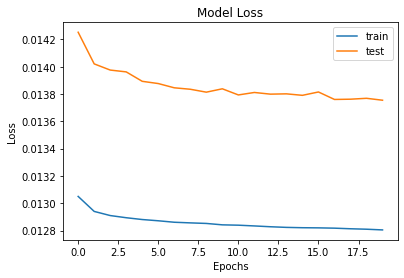

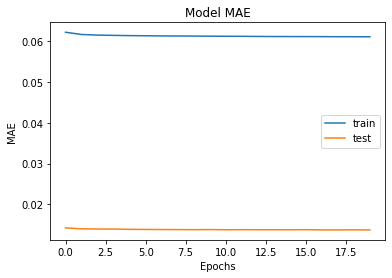

In [82]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history16.history['loss'], label='train')
pyplot.plot(history16.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

print("\n")
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history16.history['mae'], label='train')
pyplot.plot(history16.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [83]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict16 = model16.predict(train_X)
train_predict16_dataset_like = np.zeros(shape=(len(train_predict16), 40))
# put the predicted values in the right field
train_predict16_dataset_like[:,0] = train_predict16[:,0]
# inverse transform and then select the right field
train_predict16 = scaler.inverse_transform(train_predict16_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict16[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict16[:])))

print("\n")

test_predict16 = model16.predict(test_X)
test_predict16_dataset_like = np.zeros(shape=(len(test_predict16), 40))
# invert predictions
test_predict16_dataset_like[:,0] = test_predict16[:,0]
# inverse transform and then select the right field
test_predict16 = scaler.inverse_transform(test_predict16_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict16[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict16[:])))

Train Mean Absolute Error: 23.82211395283967
Train Root Mean Squared Error: 27.383005759833143


Test Mean Absolute Error: 24.258300871221987
Test Root Mean Squared Error: 27.790583649889385


In [84]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat16= model16.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat16= concatenate((yhat16, test_X[:, 1:]), axis=1)
inv_yhat16= scaler.inverse_transform(inv_yhat16)
inv_yhat16= inv_yhat16[:,0]

print("Predicted Metric Tons")
print(inv_yhat16)
print("\n")
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat16))
print("\n")
print("Predicted Average")
print(np.average(inv_yhat16))

Predicted Metric Tons
[18.942724 10.01722   9.997635 ... 30.255804 40.31763  36.924183]


Predicted Max Metric Tons
178.96661


Predicted Average
24.345816


In [85]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y16 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y16 = scaler.inverse_transform(inv_y16)
inv_y16 = inv_y16[:,0]

print("Actual Metric Tons")
print(inv_y16)
print("\n")
print("Actual Max Metric Tons")
print(np.amax(inv_y16))
print("\n")
print("Actual Average Metric Tons")
print(np.average(inv_y16))

Actual Metric Tons
[ 0.15  0.11  0.23 ...  9.2  13.14 19.43]


Actual Max Metric Tons
249.99


Actual Average Metric Tons
21.897882


In [86]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y16, inv_yhat16))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y16, inv_yhat16))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y16, inv_yhat16))
print('R2 : %3f' % r2_score(inv_y16, inv_yhat16))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 17.093540
Mean Square Error (MSE): 859.604126
R2 : 0.145987


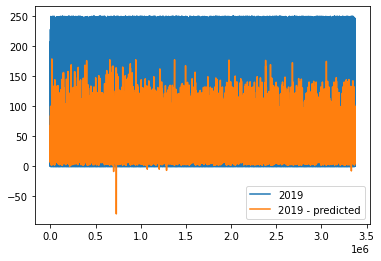

In [87]:
pyplot.plot(inv_y16, label = '2019')
pyplot.plot(inv_yhat16, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#

In [88]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model17 = Sequential()
model17.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model17.add(Dropout(0.15))
model17.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model17.compile(loss='mse', optimizer='adam', metrics=['mae'])
model17.summary()

(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [89]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2020_test2019_n50_b64_epochs20_crossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [90]:
history17 = model17.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y), shuffle=False,
                    callbacks=callbacks_list)

model17.save('./210421_Model_50neuron_batch32_20epochs_train2020_crossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210421_Model_50neuron_batch32_20epochs_train2020_crossval_tf')

Epoch 1/20
102041/102041 [==============================] - 783s 8ms/step - loss: 0.0137 - mae: 0.0643 - val_loss: 0.0140 - val_mae: 0.0713
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs20_crossval\assets
Epoch 2/20
102041/102041 [==============================] - 827s 8ms/step - loss: 0.0134 - mae: 0.0632 - val_loss: 0.0139 - val_mae: 0.0694
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs20_crossval\assets
Epoch 3/20
102041/102041 [==============================] - 822s 8ms/step - loss: 0.0134 - mae: 0.0631 - val_loss: 0.0140 - val_mae: 0.0705
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs20_crossval\assets
Epoch 4/20
102041/102041 [==============================] - 802s 8ms/step - loss: 0.0134 - mae: 0.0630 - val_loss: 0.0140 - val_mae: 0.0703
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs20_crossval\assets
Epoch 5/20
102041/102041 [==============

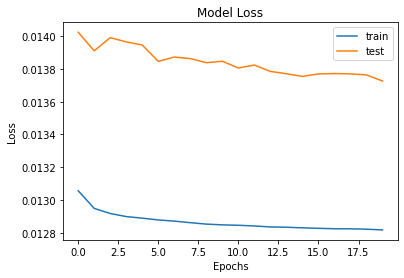

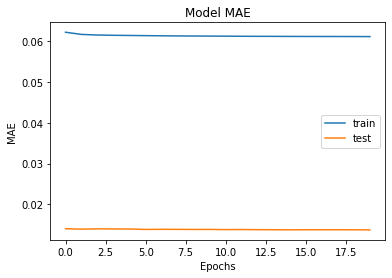

In [91]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history17.history['loss'], label='train')
pyplot.plot(history17.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

print("\n")
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history17.history['mae'], label='train')
pyplot.plot(history17.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [92]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict17 = model17.predict(train_X)
train_predict17_dataset_like = np.zeros(shape=(len(train_predict17), 40))
# put the predicted values in the right field
train_predict17_dataset_like[:,0] = train_predict17[:,0]
# inverse transform and then select the right field
train_predict17 = scaler.inverse_transform(train_predict17_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict17[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict17[:])))

print("\n")

test_predict17 = model17.predict(test_X)
test_predict17_dataset_like = np.zeros(shape=(len(test_predict17), 40))
# invert predictions
test_predict17_dataset_like[:,0] = test_predict17[:,0]
# inverse transform and then select the right field
test_predict17 = scaler.inverse_transform(test_predict17_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict17[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict17[:])))

Train Mean Absolute Error: 24.229561727813046
Train Root Mean Squared Error: 27.84015688177404


Test Mean Absolute Error: 23.443610715199114
Test Root Mean Squared Error: 26.909902138919826


In [93]:

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat17= model17.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat17= concatenate((yhat17, test_X[:, 1:]), axis=1)
inv_yhat17= scaler.inverse_transform(inv_yhat17)
inv_yhat17= inv_yhat17[:,0]

print("Predicted Metric Tons")
print(inv_yhat17)
print("\n")
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat17))
print("\n")
print("Predicted Average")
print(np.average(inv_yhat17))

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y17 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y17 = scaler.inverse_transform(inv_y17)
inv_y17 = inv_y17[:,0]

print("Actual Metric Tons")
print(inv_y17)
print("\n")
print("Actual Max Metric Tons")
print(np.amax(inv_y17))
print("\n")
print("Actual Average Metric Tons")
print(np.average(inv_y17))

Predicted Metric Tons
[17.99776  11.592834 11.576897 ... 32.09448  35.993843 34.001762]


Predicted Max Metric Tons
191.20432


Predicted Average
23.530588
Actual Metric Tons
[ 0.15  0.11  0.23 ...  9.2  13.14 19.43]


Actual Max Metric Tons
249.99


Actual Average Metric Tons
21.897882


In [94]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y17, inv_yhat17))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y17, inv_yhat17))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y17, inv_yhat17))
print('R2 : %3f' % r2_score(inv_y17, inv_yhat17))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 16.726904
Mean Square Error (MSE): 857.798523
R2 : 0.147780


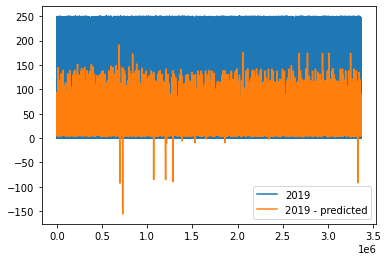

In [95]:
pyplot.plot(inv_y17, label = '2019')
pyplot.plot(inv_yhat17, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#

In [96]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model18 = Sequential()
model18.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model18.add(Dropout(0.15))
model18.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model18.compile(loss='mse', optimizer='adam', metrics=['mae'])
model18.summary()

(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [97]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2020_test2019_n50_b16_epochs20_crossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [98]:
history18 = model18.fit(train_X, train_y, epochs=20, batch_size=16, validation_data=(test_X, test_y), shuffle=False,
                    callbacks=callbacks_list)

model18.save('./210421_Model_50neuron_batch16_20epochs_train2020_crossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210421_Model_50neuron_batch16_20epochs_train2020_crossval_tf')

Epoch 1/20
204081/204081 [==============================] - 1597s 8ms/step - loss: 0.0136 - mae: 0.0642 - val_loss: 0.0140 - val_mae: 0.0679
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs20_crossval\assets
Epoch 2/20
204081/204081 [==============================] - 1448s 7ms/step - loss: 0.0135 - mae: 0.0634 - val_loss: 0.0139 - val_mae: 0.0679
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs20_crossval\assets
Epoch 3/20
204081/204081 [==============================] - 1604s 8ms/step - loss: 0.0134 - mae: 0.0632 - val_loss: 0.0139 - val_mae: 0.0680
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs20_crossval\assets
Epoch 4/20
204081/204081 [==============================] - 1520s 7ms/step - loss: 0.0134 - mae: 0.0632 - val_loss: 0.0139 - val_mae: 0.0672
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs20_crossval\assets
Epoch 5/20
204081/204081 [==========

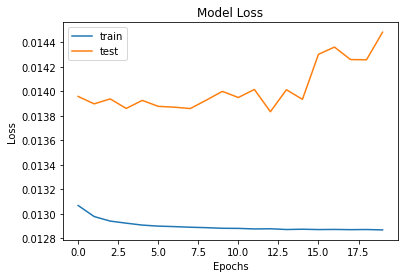

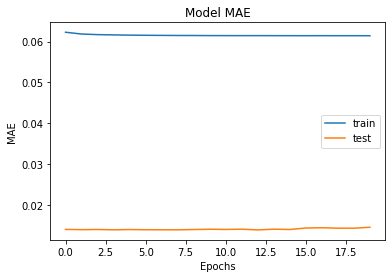

In [99]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history18.history['loss'], label='train')
pyplot.plot(history18.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

print("\n")
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history18.history['mae'], label='train')
pyplot.plot(history18.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [100]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict18 = model18.predict(train_X)
train_predict18_dataset_like = np.zeros(shape=(len(train_predict18), 40))
# put the predicted values in the right field
train_predict18_dataset_like[:,0] = train_predict18[:,0]
# inverse transform and then select the right field
train_predict18 = scaler.inverse_transform(train_predict18_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict18[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict18[:])))

print("\n")

test_predict18 = model18.predict(test_X)
test_predict18_dataset_like = np.zeros(shape=(len(test_predict18), 40))
# invert predictions
test_predict18_dataset_like[:,0] = test_predict18[:,0]
# inverse transform and then select the right field
test_predict18 = scaler.inverse_transform(test_predict18_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict18[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict18[:])))

Train Mean Absolute Error: 24.79131761537087
Train Root Mean Squared Error: 30.023902316941843


Test Mean Absolute Error: 19.80419964787857
Test Root Mean Squared Error: 24.201632161547472


In [101]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat18= model18.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat18= concatenate((yhat18, test_X[:, 1:]), axis=1)
inv_yhat18= scaler.inverse_transform(inv_yhat18)
inv_yhat18= inv_yhat18[:,0]

print("Predicted Metric Tons")
print(inv_yhat18)
print("\n")
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat18))
print("\n")
print("Predicted Average")
print(np.average(inv_yhat18))

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y18 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y18 = scaler.inverse_transform(inv_y18)
inv_y18 = inv_y18[:,0]

print("Actual Metric Tons")
print(inv_y18)
print("\n")
print("Actual Max Metric Tons")
print(np.amax(inv_y18))
print("\n")
print("Actual Average Metric Tons")
print(np.average(inv_y18))

Predicted Metric Tons
[ 7.608039   -0.54003376 -0.55296    ... 18.514193   33.634876
 39.119514  ]


Predicted Max Metric Tons
234.1283


Predicted Average
18.660715
Actual Metric Tons
[ 0.15  0.11  0.23 ...  9.2  13.14 19.43]


Actual Max Metric Tons
249.99


Actual Average Metric Tons
21.897882


In [102]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y18, inv_yhat18))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y18, inv_yhat18))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y18, inv_yhat18))
print('R2 : %3f' % r2_score(inv_y18, inv_yhat18))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Mean Absolute Error (MAE): 16.823891
Mean Square Error (MSE): 905.052917
R2 : 0.100833


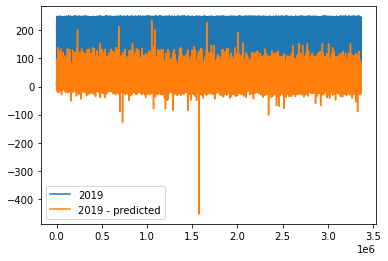

In [103]:
pyplot.plot(inv_y18, label = '2019')
pyplot.plot(inv_yhat18, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [104]:
#

In [105]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model19 = Sequential()
model19.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model19.add(Dropout(0.15))
model19.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model19.compile(loss='mse', optimizer='adam', metrics=['mae'])
model19.summary()

(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [106]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2020_test2019_n50_b32_epochs30_crossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [107]:
history19 = model19.fit(train_X, train_y, epochs=30, batch_size=32, validation_data=(test_X, test_y), shuffle=False,
                    callbacks=callbacks_list)

model19.save('./210421_Model_50neuron_batch32_30epochs_train2020_crossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210421_Model_50neuron_batch32_30epochs_train2020_crossval_tf')

Epoch 1/30
102041/102041 [==============================] - 712s 7ms/step - loss: 0.0136 - mae: 0.0642 - val_loss: 0.0141 - val_mae: 0.0712
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b32_epochs30_crossval\assets
Epoch 2/30
102041/102041 [==============================] - 723s 7ms/step - loss: 0.0135 - mae: 0.0632 - val_loss: 0.0140 - val_mae: 0.0710
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b32_epochs30_crossval\assets
Epoch 3/30
102041/102041 [==============================] - 774s 8ms/step - loss: 0.0134 - mae: 0.0631 - val_loss: 0.0140 - val_mae: 0.0699
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b32_epochs30_crossval\assets
Epoch 4/30
102041/102041 [==============================] - 755s 7ms/step - loss: 0.0134 - mae: 0.0630 - val_loss: 0.0139 - val_mae: 0.0690
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b32_epochs30_crossval\assets
Epoch 5/30
102041/102041 [==============

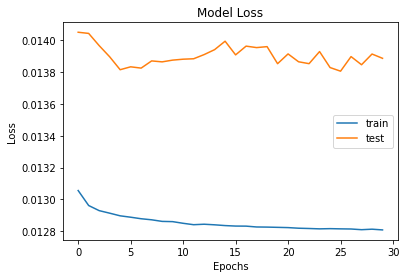

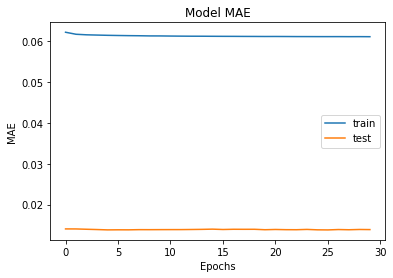

In [108]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history19.history['loss'], label='train')
pyplot.plot(history19.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

print("\n")
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history19.history['mae'], label='train')
pyplot.plot(history19.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [109]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict19 = model19.predict(train_X)
train_predict19_dataset_like = np.zeros(shape=(len(train_predict19), 40))
# put the predicted values in the right field
train_predict19_dataset_like[:,0] = train_predict19[:,0]
# inverse transform and then select the right field
train_predict19 = scaler.inverse_transform(train_predict19_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict19[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict19[:])))

print("\n")

test_predict19 = model19.predict(test_X)
test_predict19_dataset_like = np.zeros(shape=(len(test_predict19), 40))
# invert predictions
test_predict19_dataset_like[:,0] = test_predict19[:,0]
# inverse transform and then select the right field
test_predict19 = scaler.inverse_transform(test_predict19_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict19[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict19[:])))

Train Mean Absolute Error: 24.439040856279437
Train Root Mean Squared Error: 28.595126143927857


Test Mean Absolute Error: 23.713324072136995
Test Root Mean Squared Error: 27.151333366435107


In [110]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat18= model19.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat19= concatenate((yhat18, test_X[:, 1:]), axis=1)
inv_yhat19= scaler.inverse_transform(inv_yhat19)
inv_yhat19= inv_yhat19[:,0]

print("Predicted Metric Tons")
print(inv_yhat19)
print("\n")
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat19))
print("\n")
print("Predicted Average")
print(np.average(inv_yhat19))

Predicted Metric Tons
[18.923857 11.588679 11.573671 ... 30.741589 34.318245 35.330376]


Predicted Max Metric Tons
227.87218


Predicted Average
23.800718


In [111]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y19 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y19 = scaler.inverse_transform(inv_y19)
inv_y19 = inv_y19[:,0]

print("Actual Metric Tons")
print(inv_y19)
print("\n")
print("Actual Max Metric Tons")
print(np.amax(inv_y19))
print("\n")
print("Actual Average Metric Tons")
print(np.average(inv_y19))

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y19, inv_yhat19))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y19, inv_yhat19))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y19, inv_yhat19))
print('R2 : %3f' % r2_score(inv_y19, inv_yhat19))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Actual Metric Tons
[ 0.15  0.11  0.23 ...  9.2  13.14 19.43]


Actual Max Metric Tons
249.99


Actual Average Metric Tons
21.897882
Mean Absolute Error (MAE): 16.933146
Mean Square Error (MSE): 867.881897
R2 : 0.137763


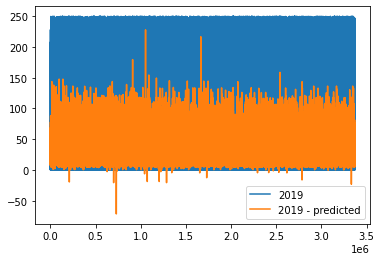

In [112]:
pyplot.plot(inv_y19, label = '2019')
pyplot.plot(inv_yhat19, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#

In [41]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model20 = Sequential()
model20.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model20.add(Dropout(0.15))
model20.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model20.compile(loss='mse', optimizer='adam', metrics=['mae'])
model20.summary()


(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                18200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [42]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2020_test2019_n50_b64_epochs30_crossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

In [43]:
history20 = model20.fit(train_X, train_y, epochs=30, batch_size=64, validation_data=(test_X, test_y), shuffle=False,
                    callbacks=callbacks_list)

model20.save('./210424_Model_50neuron_batch64_30epochs_train2020_crossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210424_Model_50neuron_batch64_30epochs_train2020_crossval_tf')

Epoch 1/30
51021/51021 [==============================] - 600s 12ms/step - loss: 0.0137 - mae: 0.0644 - val_loss: 0.0141 - val_mae: 0.0732
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs30_crossval\assets
Epoch 2/30
51021/51021 [==============================] - 547s 11ms/step - loss: 0.0134 - mae: 0.0632 - val_loss: 0.0141 - val_mae: 0.0722
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs30_crossval\assets
Epoch 3/30
51021/51021 [==============================] - 591s 12ms/step - loss: 0.0134 - mae: 0.0630 - val_loss: 0.0139 - val_mae: 0.0702
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs30_crossval\assets
Epoch 4/30
51021/51021 [==============================] - 553s 11ms/step - loss: 0.0134 - mae: 0.0629 - val_loss: 0.0139 - val_mae: 0.0703
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b64_epochs30_crossval\assets
Epoch 5/30
51021/51021 [====================

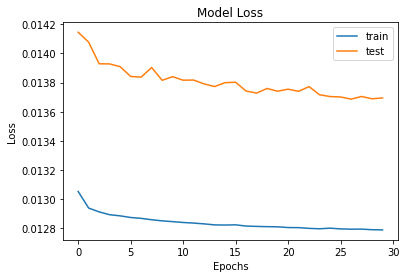

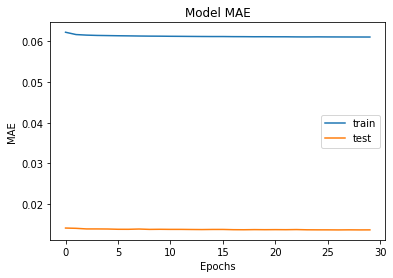

In [44]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history20.history['loss'], label='train')
pyplot.plot(history20.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

print("\n")
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history20.history['mae'], label='train')
pyplot.plot(history20.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [45]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict20 = model20.predict(train_X)
train_predict20_dataset_like = np.zeros(shape=(len(train_predict20), 40))
# put the predicted values in the right field
train_predict20_dataset_like[:,0] = train_predict20[:,0]
# inverse transform and then select the right field
train_predict20 = scaler.inverse_transform(train_predict20_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict20[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict20[:])))

print("\n")

test_predict20 = model20.predict(test_X)
test_predict20_dataset_like = np.zeros(shape=(len(test_predict20), 40))
# invert predictions
test_predict20_dataset_like[:,0] = test_predict20[:,0]
# inverse transform and then select the right field
test_predict20 = scaler.inverse_transform(test_predict20_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict20[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict20[:])))

Train Mean Absolute Error: 23.879193721851976
Train Root Mean Squared Error: 27.83860537648786


Test Mean Absolute Error: 23.615648534086468
Test Root Mean Squared Error: 27.230344778198074


In [46]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat20= model20.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat20= concatenate((yhat20, test_X[:, 1:]), axis=1)
inv_yhat20= scaler.inverse_transform(inv_yhat20)
inv_yhat20= inv_yhat20[:,0]

print("Predicted Metric Tons")
print(inv_yhat20)
print("\n")
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat20))
print("\n")
print("Predicted Average")
print(np.average(inv_yhat20))

Predicted Metric Tons
[19.158127  9.507323  9.488238 ... 31.442108 39.00013  36.822216]


Predicted Max Metric Tons
193.77802


Predicted Average
23.702826


In [47]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y20 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y20 = scaler.inverse_transform(inv_y20)
inv_y20 = inv_y20[:,0]

print("Actual Metric Tons")
print(inv_y20)
print("\n")
print("Actual Max Metric Tons")
print(np.amax(inv_y20))
print("\n")
print("Actual Average Metric Tons")
print(np.average(inv_y20))

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y20, inv_yhat20))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y20, inv_yhat20))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y20, inv_yhat20))
print('R2 : %3f' % r2_score(inv_y20, inv_yhat20))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Actual Metric Tons
[ 0.15  0.11  0.23 ...  9.2  13.14 19.43]


Actual Max Metric Tons
249.99


Actual Average Metric Tons
21.897882
Mean Absolute Error (MAE): 16.793606
Mean Square Error (MSE): 855.830811
R2 : 0.149735


C:\Users\aschu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


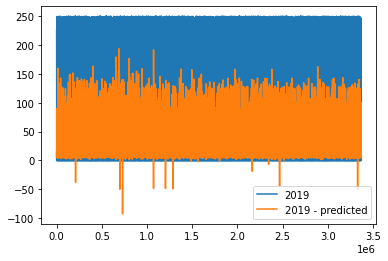

In [48]:
pyplot.plot(inv_y20, label = '2019')
pyplot.plot(inv_yhat20, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [49]:
#

In [50]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model21 = Sequential()
model21.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model21.add(Dropout(0.15))
model21.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model21.compile(loss='mse', optimizer='adam', metrics=['mae'])
model21.summary()

(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [51]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2020_test2019_n50_b16_epochs20_nocrossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [52]:
#, validation_data=(test_X, test_y)
history21 = model21.fit(train_X, train_y, epochs=20, batch_size=16, shuffle=False,
                    callbacks=callbacks_list)

model21.save('./210424_Model_50neuron_batch16_20epochs_train2020_nocrossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210424_Model_50neuron_batch16_20epochs_train2020_nocrossval_tf')

Epoch 1/20
204081/204081 [==============================] - 1197s 6ms/step - loss: 0.0137 - mae: 0.0642
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs20_nocrossval\assets
Epoch 2/20
204081/204081 [==============================] - 1163s 6ms/step - loss: 0.0135 - mae: 0.0633
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs20_nocrossval\assets
Epoch 3/20
204081/204081 [==============================] - 1162s 6ms/step - loss: 0.0134 - mae: 0.0632
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs20_nocrossval\assets
Epoch 4/20
204081/204081 [==============================] - 1111s 5ms/step - loss: 0.0134 - mae: 0.0631
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs20_nocrossval\assets
Epoch 5/20
204081/204081 [==============================] - 1115s 5ms/step - loss: 0.0134 - mae: 0.0631
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b

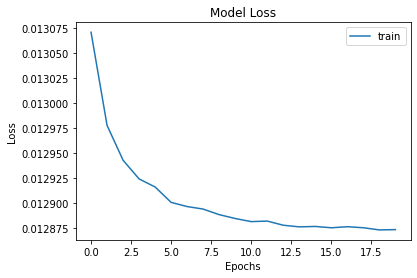

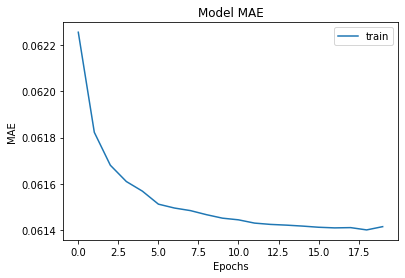

In [53]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history21.history['loss'], label='train')
#pyplot.plot(history21.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

print("\n")
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history21.history['mae'], label='train')
#pyplot.plot(history21.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [54]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict21 = model21.predict(train_X)
train_predict21_dataset_like = np.zeros(shape=(len(train_predict21), 40))
# put the predicted values in the right field
train_predict21_dataset_like[:,0] = train_predict21[:,0]
# inverse transform and then select the right field
train_predict21 = scaler.inverse_transform(train_predict21_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict21[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict21[:])))

print("\n")

test_predict21 = model21.predict(test_X)
test_predict21_dataset_like = np.zeros(shape=(len(test_predict21), 40))
# invert predictions
test_predict21_dataset_like[:,0] = test_predict21[:,0]
# inverse transform and then select the right field
test_predict21 = scaler.inverse_transform(test_predict21_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict21[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict21[:])))

Train Mean Absolute Error: 26.1984830288712
Train Root Mean Squared Error: 30.803877080402604


Test Mean Absolute Error: 22.667853429125945
Test Root Mean Squared Error: 26.348205337173386


In [55]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat21= model21.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat21= concatenate((yhat21, test_X[:, 1:]), axis=1)
inv_yhat21= scaler.inverse_transform(inv_yhat21)
inv_yhat21= inv_yhat21[:,0]

print("Predicted Metric Tons")
print(inv_yhat21)
print("\n")
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat21))
print("\n")
print("Predicted Average")
print(np.average(inv_yhat21))

Predicted Metric Tons
[18.433054  7.165874  7.146626 ... 29.959406 35.13005  35.341724]


Predicted Max Metric Tons
234.85948


Predicted Average
22.745083


In [56]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y21 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y21 = scaler.inverse_transform(inv_y21)
inv_y21 = inv_y21[:,0]

print("Actual Metric Tons")
print(inv_y21)
print("\n")
print("Actual Max Metric Tons")
print(np.amax(inv_y21))
print("\n")
print("Actual Average Metric Tons")
print(np.average(inv_y21))

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y21, inv_yhat21))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y21, inv_yhat21))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y21, inv_yhat21))
print('R2 : %3f' % r2_score(inv_y21, inv_yhat21))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Actual Metric Tons
[ 0.15  0.11  0.23 ...  9.2  13.14 19.43]


Actual Max Metric Tons
249.99


Actual Average Metric Tons
21.897882
Mean Absolute Error (MAE): 16.599600
Mean Square Error (MSE): 868.496948
R2 : 0.137151


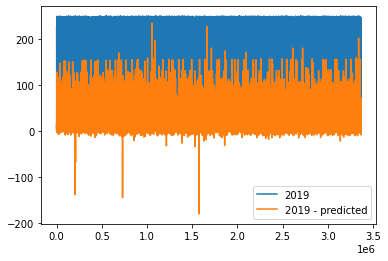

In [57]:
pyplot.plot(inv_y21, label = '2019')
pyplot.plot(inv_yhat21, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [58]:
#

In [59]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model22 = Sequential()
model22.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model22.add(Dropout(0.15))
model22.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model22.compile(loss='mse', optimizer='adam', metrics=['mae'])
model22.summary()

(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [60]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2020_test2019_n50_b16_epochs30_nocrossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [61]:
#, validation_data=(test_X, test_y)
history22 = model22.fit(train_X, train_y, epochs=30, batch_size=16, shuffle=False,
                    callbacks=callbacks_list)

model22.save('./210424_Model_50neuron_batch16_30epochs_train2020_nocrossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210424_Model_50neuron_batch16_30epochs_train2020_nocrossval_tf')

Epoch 1/30
204081/204081 [==============================] - 1185s 6ms/step - loss: 0.0136 - mae: 0.0642
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs30_nocrossval\assets
Epoch 2/30
204081/204081 [==============================] - 1161s 6ms/step - loss: 0.0135 - mae: 0.0633
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs30_nocrossval\assets
Epoch 3/30
204081/204081 [==============================] - 1200s 6ms/step - loss: 0.0134 - mae: 0.0632
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs30_nocrossval\assets
Epoch 4/30
204081/204081 [==============================] - 1199s 6ms/step - loss: 0.0134 - mae: 0.0631
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b16_epochs30_nocrossval\assets
Epoch 5/30
204081/204081 [==============================] - 1151s 6ms/step - loss: 0.0134 - mae: 0.0631
INFO:tensorflow:Assets written to: weights_only_train2020_test2019_n50_b

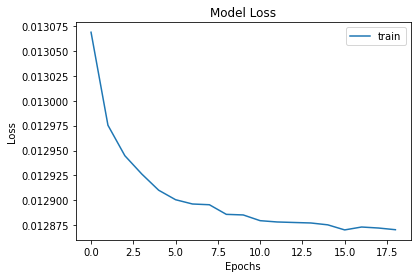

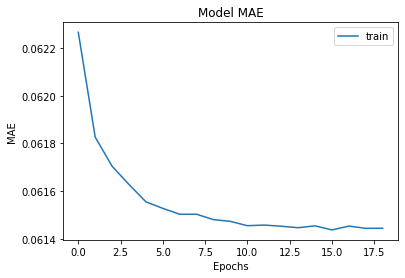

In [62]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history22.history['loss'], label='train')
#pyplot.plot(history22.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

print("\n")
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history22.history['mae'], label='train')
#pyplot.plot(history22.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [63]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict22 = model22.predict(train_X)
train_predict22_dataset_like = np.zeros(shape=(len(train_predict22), 40))
# put the predicted values in the right field
train_predict22_dataset_like[:,0] = train_predict22[:,0]
# inverse transform and then select the right field
train_predict22 = scaler.inverse_transform(train_predict22_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict22[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict22[:])))

print("\n")

test_predict22 = model22.predict(test_X)
test_predict22_dataset_like = np.zeros(shape=(len(test_predict22), 40))
# invert predictions
test_predict22_dataset_like[:,0] = test_predict22[:,0]
# inverse transform and then select the right field
test_predict22 = scaler.inverse_transform(test_predict22_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict22[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict22[:])))

Train Mean Absolute Error: 25.66949690913523
Train Root Mean Squared Error: 30.1620711556388


Test Mean Absolute Error: 22.801174316422976
Test Root Mean Squared Error: 26.116815949231622


In [64]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat22 = model22.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat22= concatenate((yhat22, test_X[:, 1:]), axis=1)
inv_yhat22= scaler.inverse_transform(inv_yhat22)
inv_yhat22= inv_yhat22[:,0]

print("Predicted Metric Tons")
print(inv_yhat22)
print("\n")
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat22))
print("\n")
print("Predicted Average")
print(np.average(inv_yhat22))

Predicted Metric Tons
[18.604548  9.886224  9.86586  ... 27.653807 41.010166 36.130424]


Predicted Max Metric Tons
201.645


Predicted Average
22.882631


In [65]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y22 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y22 = scaler.inverse_transform(inv_y22)
inv_y22 = inv_y22[:,0]

print("Actual Metric Tons")
print(inv_y22)
print("\n")
print("Actual Max Metric Tons")
print(np.amax(inv_y22))
print("\n")
print("Actual Average Metric Tons")
print(np.average(inv_y22))

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y22, inv_yhat22))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y22, inv_yhat22))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y22, inv_yhat22))
print('R2 : %3f' % r2_score(inv_y22, inv_yhat22))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

Actual Metric Tons
[ 0.15  0.11  0.23 ...  9.2  13.14 19.43]


Actual Max Metric Tons
249.99


Actual Average Metric Tons
21.897882
Mean Absolute Error (MAE): 16.557644
Mean Square Error (MSE): 860.127930
R2 : 0.145466


C:\Users\aschu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


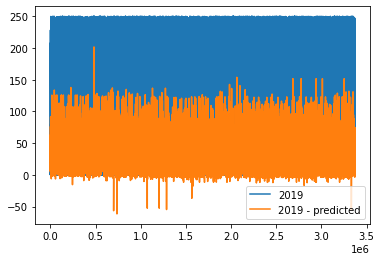

In [66]:
pyplot.plot(inv_y22, label = '2019')
pyplot.plot(inv_yhat22, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [67]:
#

In [68]:
#Train 2020
#define fit model for 2020
#3429443 - initial - remove > 250 and now = 3368492
# split into train and test sets
values = reframed.values
n_train_hours = 3368492
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from keras.callbacks import ModelCheckpoint
#input_shape=(train_X.shape[1], train_X.shape[2])
#after relu put 
# , input_shape=(1, 40), return_sequences=True)
# design network
model23 = Sequential()
model23.add(LSTM(50, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model23.add(Dropout(0.15))
model23.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model23.compile(loss='mse', optimizer='adam', metrics=['mae'])
model23.summary()

(3265292, 1, 40) (3265292,) (3368492, 1, 40) (3368492,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [69]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

filepath='weights_only_train2020_test2019_n50_b16_epochs30_crossval'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)


callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mae', save_best_only=True, mode='min'), tensorboard_callback]

#tensorboard --logdir=data/ --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [70]:
#, validation_data=(test_X, test_y)
history23 = model23.fit(train_X, train_y, validation_data=(test_X, test_y) epochs=30, batch_size=16, shuffle=False,
                    callbacks=callbacks_list)

model23.save('./210424_Model_50neuron_batch16_30epochs_train2020_crossval_tf', save_format='tf')

#loaded_model = tf.keras.models.load_model('./210424_Model_50neuron_batch16_30epochs_train2020_nocrossval_tf')

SyntaxError: invalid syntax (<ipython-input-70-ad9c96896633>, line 2)

In [ ]:
import matplotlib as plt
from matplotlib import pyplot
# plot history
pyplot.title('Model Loss')
pyplot.plot(history23.history['loss'], label='train')
pyplot.plot(history23.history['val_loss'], label='test')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

print("\n")
from matplotlib import pyplot
# plot history
pyplot.title('Model MAE')
pyplot.plot(history23.history['mae'], label='train')
pyplot.plot(history23.history['val_loss'], label='test')
pyplot.ylabel('MAE')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()

In [ ]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Make Predictions
# create empty table with 40fields
train_predict23 = model23.predict(train_X)
train_predict23_dataset_like = np.zeros(shape=(len(train_predict23), 40))
# put the predicted values in the right field
train_predict23_dataset_like[:,0] = train_predict23[:,0]
# inverse transform and then select the right field
train_predict23 = scaler.inverse_transform(train_predict23_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict23[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict23[:])))

print("\n")

test_predict23 = model23.predict(test_X)
test_predict23_dataset_like = np.zeros(shape=(len(test_predict23), 40))
# invert predictions
test_predict23_dataset_like[:,0] = test_predict23[:,0]
# inverse transform and then select the right field
test_predict23 = scaler.inverse_transform(test_predict23_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict23[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict23[:])))

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# make a prediction
yhat22 = model23.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

# invert scaling for forecast
inv_yhat23= concatenate((yhat22, test_X[:, 1:]), axis=1)
inv_yhat23= scaler.inverse_transform(inv_yhat23)
inv_yhat23= inv_yhat23[:,0]

print("Predicted Metric Tons")
print(inv_yhat23)
print("\n")
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat23))
print("\n")
print("Predicted Average")
print(np.average(inv_yhat23))

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y23 = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y23 = scaler.inverse_transform(inv_y23)
inv_y23 = inv_y23[:,0]

print("Actual Metric Tons")
print(inv_y23)
print("\n")
print("Actual Max Metric Tons")
print(np.amax(inv_y23))
print("\n")
print("Actual Average Metric Tons")
print(np.average(inv_y23))

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y23, inv_yhat23))
#print('Test RMSE: %.3f' % rmse)
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y23, inv_yhat23))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y23, inv_yhat23))
print('R2 : %3f' % r2_score(inv_y23, inv_yhat23))
#print('Mean Absolute Error (MAE): %3f' % math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat)))

In [ ]:
pyplot.plot(inv_y23, label = '2019')
pyplot.plot(inv_yhat23, label = '2019 - predicted')
pyplot.legend()
pyplot.show()

In [ ]:
#

In [ ]:
#

In [49]:
%load_ext tensorboard

In [210]:
%reload_ext tensorboard
import datetime, os

In [168]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1)
  ])


In [211]:
tensorboard --logdir=data/ --host localhost --port 8088




Reusing TensorBoard on port 8088 (pid 17400), started 0:03:30 ago. (Use '!kill 17400' to kill it.)

In [206]:
#%tensorboard --logdir PATH

Reusing TensorBoard on port 6006 (pid 20568), started 0:06:37 ago. (Use '!kill 20568' to kill it.)

In [212]:


def train_model():

  model = create_model()
  model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(x=train_X, 
            y=train_y, 
            epochs=5, 
            validation_data=(test_X, test_y),
            batch_size=72, shuffle=False,
            callbacks=[tensorboard_callback])

train_model()



Epoch 1/5
47631/47632 [============================>.] - ETA: 0s - loss: 2.9164e-05 - mae: 0.0011

ValueError: in user code:

    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1233 test_function  *
        return step_function(self, iterator)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1217 run_step  **
        outputs = model.test_step(data)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1183 test_step
        y_pred = self(x, training=False)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_17 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 40)


In [63]:
%tensorboard --logdir logs


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2021-04-12 08:56:50.147351: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--whatif-use-unsafe-custom-prediction YOUR_CUSTOM_PREDICT_FUNCTION.py]
                   {serve,dev} ..

In [43]:
tensorboard --inspect --logdir DIRECTORY_PATH

ERROR: Failed to launch TensorBoard (exited with 0).
Contents of stderr:
2021-04-12 16:43:09.731441: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
Contents of stdout:
Processing event files... (this can take a few minutes)

No event files found within logdir DIRECTORY_PATH

In [61]:
train_predict

array([[[-1.36177032e-03]],

       [[ 5.77180535e-02]],

       [[ 5.77180535e-02]],

       [[ 5.32373711e-02]],

       [[ 5.77176847e-02]],

       [[ 5.77179566e-02]],

       [[ 5.77180274e-02]],

       [[ 5.32373004e-02]],

       [[ 1.69623585e-03]],

       [[ 1.69629522e-03]],

       [[ 4.34105191e-03]],

       [[-1.16209476e-03]],

       [[-1.16207008e-03]],

       [[ 3.17851314e-04]],

       [[-2.68376581e-02]],

       [[-2.68375669e-02]],

       [[-2.15254333e-02]],

       [[ 3.56495450e-03]],

       [[-1.11836540e-02]],

       [[ 1.38937193e-03]],

       [[-1.11826696e-02]],

       [[ 1.69628893e-03]],

       [[ 9.56059899e-04]],

       [[ 9.55650816e-04]],

       [[ 5.77176474e-02]],

       [[ 5.77180199e-02]],

       [[ 1.69633108e-03]],

       [[ 1.69630721e-03]],

       [[ 3.96540686e-02]],

       [[ 3.96536775e-02]],

       [[ 3.96532975e-02]],

       [[ 6.19730316e-02]],

       [[ 5.27433418e-02]],

       [[ 5.27432822e-02]],

       [[-5.37

In [79]:
#train_predict = model.predict(train_X)
#test_predict = model.predict(test_X)
# invert predictions
#train_predict = scaler.inverse_transform(train_predict)
#train_y = scaler.inverse_transform([train_y])
#test_predict = scaler.inverse_transform(test_predict)
#test_y = scaler.inverse_transform([test_y])
print('Train Mean Absolute Error:', mean_absolute_error(train_y[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(test_y[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[0], test_predict[:,0])))

ValueError: in user code:

    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 40)


In [103]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict[:])))

Train Mean Absolute Error: 2227.1387096220233
Train Root Mean Squared Error: 2672.3676216808026


8

Test Mean Absolute Error: 2908.063807156409
Test Root Mean Squared Error: 3307.5999488807756


In [104]:
#Make Predictions
# create empty table with 40fields
test_predict = model.predict(test_X)
test_predict_dataset_like = np.zeros(shape=(len(test_predict), 40) )
# put the predicted values in the right field
test_predict_dataset_like[:,0] = test_predict[:,0]
# inverse transform and then select the right field
test_predict = scaler.inverse_transform(test_predict_dataset_like)[:,0]


ValueError: in user code:

    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 40)


In [ ]:


print('Train Mean Absolute Error:', mean_absolute_error(train_y[0], train_predict[:,40]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(test_y[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[0], test_predict[:,0])))

In [53]:
#define fit model for 2019
...
# split into train and test sets
values = reframed.values
n_train_hours = 52
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(52, 1, 40) (52,) (6747446, 1, 40) (6747446,)


In [ ]:

history = model.fit(train_X, train_y, epochs=1,validation_data=(test_X, test_y), batch_size=32, shuffle=False, callbacks=[tensorboard_callback])


In [55]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [ ]:


#n_input = 12
#n_features = 1
#generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)



In [56]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

# design network
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.15))
model.add(Dense(1))
#odel.compile(loss='mae', optimizer='adam')
# fit network
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 18,251
Trainable params: 18,251
Non-trainable params: 0
_________________________________________________________________


In [58]:
%load_ext tensorboard

In [62]:
history = model.fit(train_X, train_y, epochs=50,validation_data=(test_X, test_y), batch_size=32, shuffle=False, callbacks=[tensorboard_callback])


Epoch 1/50
2/2 [==============================] - 633s 633s/step - loss: 0.0013 - mae: 0.0288 - val_loss: 0.0014 - val_mae: 0.0289
Epoch 2/50
2/2 [==============================] - 620s 620s/step - loss: 0.0011 - mae: 0.0265 - val_loss: 0.0013 - val_mae: 0.0278
Epoch 3/50
2/2 [==============================] - 584s 584s/step - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0012 - val_mae: 0.0274
Epoch 4/50
2/2 [==============================] - 651s 651s/step - loss: 4.5677e-04 - mae: 0.0161 - val_loss: 0.0012 - val_mae: 0.0279
Epoch 5/50
2/2 [==============================] - 557s 557s/step - loss: 7.2798e-04 - mae: 0.0213 - val_loss: 0.0012 - val_mae: 0.0285
Epoch 6/50
2/2 [==============================] - 648s 648s/step - loss: 6.4920e-04 - mae: 0.0211 - val_loss: 0.0012 - val_mae: 0.0285
Epoch 7/50
2/2 [==============================] - 626s 626s/step - loss: 6.0283e-04 - mae: 0.0207 - val_loss: 0.0012 - val_mae: 0.0280
Epoch 8/50
2/2 [==============================] - 541s 541s/step - 

In [83]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y[0], train_predict[:,40]))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [73]:
train_predict.shape

(52, 1)

In [74]:

test_predict.shape

(6747446, 1)

In [ ]:
#Compare Actual vs. Prediction

#For me, every time step is one minute. If you resampled the data over hour earlier, then every time step is
#one hour for you.

#I will compare the actual and predictions for the last 200 minutes.

aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, test_y[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Metric Tons', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [98]:
#%tensorboard -- logdir={log_folder}

# Load the TensorBoard notebook extension.
%reload_ext tensorboard

%tensorboard --logdir log


Reusing TensorBoard on port 6006 (pid 18840), started 6:38:20 ago. (Use '!kill 18840' to kill it.)

In [97]:
rm -rf log_dir


SyntaxError: invalid syntax (<ipython-input-97-98e68ad83da0>, line 1)

In [30]:
dataset = train_df.values #numpy.ndarray
from sklearn.preprocessing import MinMaxScaler
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train = dataset

In [31]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
X_train, Y_train = create_dataset(train, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [33]:
X_train

array([[[1.0444992e-08, 2.7789942e-05, 5.4316135e-10, 5.4316135e-10,
         2.1726454e-09]],

       [[2.7789942e-05, 5.4316135e-10, 5.4316135e-10, 2.1726454e-09,
         8.1474205e-09]],

       [[5.4316135e-10, 5.4316135e-10, 2.1726454e-09, 8.1474205e-09,
         0.0000000e+00]],

       ...,

       [[0.0000000e+00, 5.4316135e-10, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00]],

       [[5.4316135e-10, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00]]], dtype=float32)

In [32]:
dataset = test_df.values #numpy.ndarray
from sklearn.preprocessing import MinMaxScaler
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test = dataset

In [91]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
#, validation_data=(X_test, Y_test),
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss',
                                                                                         patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [32]:
from sklearn.preprocessing import MinMaxScaler
train = train_df
train_df = train_df.copy()
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
test_df = test_df.copy()
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [78]:
from keras.preprocessing.sequence import TimeseriesGenerator
X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,:1]

X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,:1]
# Create overlapping windows of lagged values for training and testing datasets

timesteps = 52
train_generator = TimeseriesGenerator(X_train, y_train, length=timesteps, sampling_rate=1, batch_size=timesteps)
test_generator = TimeseriesGenerator(X_test, y_test, length=timesteps, sampling_rate=1, batch_size=timesteps)



In [79]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

ValueError: Must pass 2-d input. shape=(3429443, 1, 39)

In [76]:
##5. Model Training

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,  Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
import mlflow
import mlflow.keras


# LSTM expects the input data in a specific 3D format of test sample size, time steps, no. of input features. We had defined the time steps as n_lag variable in previous step.  Time steps are the past observations that the network will learn from (e.g. backpropagation through time).

# For details on what individual hyperparameters mean, see here: https://github.com/keras-team/keras/blob/master/keras/layers/recurrent.py#L2051

units = 128
num_epoch = 30
learning_rate = 0.00144
#experiment_id=3133492, nested=True
#with mlflow.start_run():

  model = Sequential()
  model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LeakyReLU(alpha=0.5)) 
  model.add(Dropout(0.1))
  model.add(Dense(1))

  adam = Adam(lr=learning_rate)
  # Stop training when a monitored quantity has stopped improving.
  callback = [EarlyStopping(monitor="loss", min_delta = 0.00001, patience = 50, mode = 'auto', restore_best_weights=True), tensorboard] 

  # Using regression loss function 'Mean Standard Error' and validation metric 'Mean Absolute Error'
  model.compile(loss='mse', optimizer=adam, metrics=['mae'])

# fit network
  history = model.fit_generator(train_generator, \
                                epochs=num_epoch, \
                                validation_data=test_generator, \
                                callbacks = callback, \
                                verbose=2, \
                                shuffle=False, \
                                initial_epoch=0)

 # mlflow.log_param("Units", units)
 # mlflow.log_param("Epochs", num_epoch)
 # mlflow.log_param("Learning Rate", learning_rate)
 # mlflow.log_param("Lags cosidered", timesteps)

#   Return loss value and metric value
 # score = model.evaluate_generator(test_generator, verbose=0)   
 # mlflow.log_metric("Test Loss", score[0]) 
 # mlflow.log_metric("MAE", score[1])   
 # mlflow.log_metric("Actual Epochs", len(history.history['loss']))
 # mlflow.keras.log_model(model, "LSTM Model")
    
  # The model can be saved for future use and move to production
#   mlflow.keras.save_model(model1, "/dbfs/ved-demo/timeseries/best-appliance-model/")


IndexError: tuple index out of range

In [70]:
X_train, y_train = train_generator[0]
X_test, y_test = test_generator[0]

train_samples = X_train.shape[0]*len(train_generator)
test_samples = X_test.shape[0]*len(test_generator)

print("Total Records (n): {}".format(len(results)))
#rint("Total Records after adjusting for 24 hours: {}".format(len(X)))
print("Number of samples in training set (.8 * n): trainX = {}".format(X_train.shape[0]))
print("Number of samples in testing set (.2 * n): testX = {}".format(X_test.shape[0]))
print("Size of individual batches: {}".format(X_test.shape[1]))
print("Number of total samples in training feature set: {}".format(train_samples))
print("Number of samples in testing feature set: {}".format(test_samples))

KeyError: 52

In [33]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [34]:
# For this case, let's assume that
# Given past 10 days observation, forecast the next 5 days observations. 
n_past = 12
n_future = 12
n_features = 40

In [35]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [36]:
train_df.dtypes

Metric_Tons                                                 float32
TCVUSD                                                      float32
us_company_size                                             float32
foreign_company_size                                        float32
US_Unemployment_Rate                                        float32
Average_Tariff                                              float32
cases_weekly                                                float32
deaths_weekly                                               float32
State_Closure_EA_Diff                                       float32
cases_pctdelta                                              float32
deaths_pctdelta                                             float32
Delta_Case0_Effective                                       float32
HS_Group_Name_Edible                                        float32
HS_Group_Name_Edible with Processing                        float32
HS_Group_Name_Finished Goods                    

In [57]:
X_test.shape


(3429420, 12, 40)

In [38]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



TensorFlow version: 2.4.1
Eager execution is: True
Keras version: 2.4.0
Num GPUs Available:  1


In [39]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


In [40]:
#To a save a Jupyter Notebook Session simply execute the command below:
#takes forever
#import dill
#dill.dump_session('210411_COVID_DL.db')



In [41]:
%load_ext tensorboard
#log_folder = 'logs'

import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [42]:
from tensorflow.keras.callbacks import TensorBoard

callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)]

In [55]:
# E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer. 
# n_features ==> no of features at each timestep in the data.
#
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(10, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(10, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 12, 40)]     0                                            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 10), (None,  2040        input_6[0][0]                    
__________________________________________________________________________________________________
repeat_vector_5 (RepeatVector)  (None, 12, 10)       0           lstm_12[0][0]                    
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 12, 10)       840         repeat_vector_5[0][0]            
                                                                 lstm_12[0][1]              

In [56]:
history = model.fit(X_train, y_train, epochs=50, batch_size=30, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/50


ValueError: in user code:

    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:755 train_step
        loss = self.compiled_loss(
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:1231 mean_absolute_error
        return K.mean(math_ops.abs(y_pred - y_true), axis=-1)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\math_ops.py:1180 binary_op_wrapper
        raise e
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\math_ops.py:561 subtract
        return gen_math_ops.sub(x, y, name)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\gen_math_ops.py:10315 sub
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:3528 _create_op_internal
        ret = Operation(
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 30 and 12 for '{{node mean_absolute_error/sub}} = Sub[T=DT_FLOAT](sequential_4/dense_3/BiasAdd, IteratorGetNext:1)' with input shapes: [30,1], [30,12,40].


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [49]:
# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=30, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


Epoch 1/50


ValueError: in user code:

    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:755 train_step
        loss = self.compiled_loss(
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:1231 mean_absolute_error
        return K.mean(math_ops.abs(y_pred - y_true), axis=-1)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\math_ops.py:1180 binary_op_wrapper
        raise e
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\math_ops.py:561 subtract
        return gen_math_ops.sub(x, y, name)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\gen_math_ops.py:10315 sub
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:3528 _create_op_internal
        ret = Operation(
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 30 and 12 for '{{node mean_absolute_error/sub}} = Sub[T=DT_FLOAT](sequential_4/dense_3/BiasAdd, IteratorGetNext:1)' with input shapes: [30,1], [30,12,40].


In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
model = Sequential()
model.add(LSTM(100, input_shape=(n_past, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20


ValueError: in user code:

    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:755 train_step
        loss = self.compiled_loss(
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:1198 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\gen_math_ops.py:10249 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:3528 _create_op_internal
        ret = Operation(
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\aschu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 30 and 12 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense/BiasAdd, IteratorGetNext:1)' with input shapes: [30,1], [30,12,40].


In [ ]:
model_e1d1.summary()
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

In [43]:
%tensorboard -- logdir={log_folder}

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2021-04-11 19:42:04.964103: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--whatif-use-unsafe-custom-prediction YOUR_CUSTOM_PREDICT_FUNCTION.py]
                   {serve,dev} ..

In [ ]:
#Make Predictions

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [8]:
# E2D2 Sequence to Sequence Model with two encoder layers and two decoder layers. 
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

NameError: name 'tf' is not defined

In [75]:
#%tensorboard -- logdir={log_folder}

# Load the TensorBoard notebook extension.
%load_ext tensorboard

%tensorboard --logdir log

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 18452.

In [ ]:
To restore a Jupyter Notebook session:

import dill
dill.load_session('210411_COVID_DL.db')

In [ ]:
#reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
#callbacks=[reduce_lr])

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=callabacks)


In [219]:
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=callbacks)

In [221]:
result1[['DateTime_YearMonth']].value_counts()

DateTime_YearMonth
2020-10               329052
2020-08               317135
2020-09               303536
2019-08               299778
2019-07               299265
2019-10               298695
2019-05               297469
2019-01               296694
2019-04               286879
2020-12               286436
2020-01               286191
2020-11               285234
2019-09               284766
2020-07               283925
2019-12               281768
2019-11               275341
2019-03               275108
2019-06               274101
2020-04               261116
2019-02               259579
2020-03               250358
2020-02               245082
2020-06               239254
2020-05               230737
dtype: int64

In [212]:
from sklearn.preprocessing import MinMaxScaler

values = result.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [213]:
# Create features and label dataset. NOTE: We're predicting a value 24 hours into the future.
X = scaled[:][:-84] # All of the above columns and remove readings from last 60 days
y = scaled[:, 0][84:] # Appliances or the target/label column and remove readings from first 24 hours

In [214]:
#3. Train-Test Split and create Lagged Sequences
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

# split into train and test sets
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = False)

# Create overlapping windows of lagged values for training and testing datasets
timesteps = 252
train_generator = TimeseriesGenerator(trainX, trainY, length=timesteps, sampling_rate=1, batch_size=timesteps)
test_generator = TimeseriesGenerator(testX, testY, length=timesteps, sampling_rate=1, batch_size=timesteps)


In [ ]:
4. Data Validation

Total number of samples in our data (n) = 6747499

Total number of samples in our data after adjusting for 24 hours (n - 144) = 19591

Before Time series Generator:

    Number of samples in training set (.8 * n) = 15672
    Number of samples in testing set (.2 * n) = 3919

After Time series Generator:

    Number of samples in the training feature set = 15552
    Number of samples in the testing label set = 3456
    The shape of the input set should be (batch_size, timesteps, input_dim) [https://keras.io/layers/recurrent/].

In step 1, we choose all columns except date, so our input dimension will be 28.


In [215]:
result.shape

(6747499, 40)

In [200]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [211]:
#did not work
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from keras.preprocessing.sequence import TimeseriesGenerator
#import numpy as np 

#values = result.values() # should return a list 
#values = values.astype('float32')

# Normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)


TypeError: 'numpy.ndarray' object is not callable

In [201]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

NameError: name 'DataFrame' is not defined

In [ ]:
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [165]:
#did not use bcuz it loses the names of the variables when one hot encoding
import numpy as np
import pandas as pd              # version 0.23.4
import category_encoders as ce   # version 1.2.8
from sklearn.preprocessing import LabelEncoder

#one hot encoding
#keeping trade direction in model but prob should be removed for filtering
ce_one_hot = ce.OneHotEncoder(cols = ['HS_Group_Name', 'Container_LCL/FCL', 'Foreign_Country_Region',
                                     'US_Port_Coastal_Region','Trade_Direction'])
ce_one_hot.fit_transform(X, y)

,Metric_Tons,Container_LCL/FCL_1,Container_LCL/FCL_2,Container_Type_Dry,TCVUSD,Trade_Direction_1,Trade_Direction_2,us_company_size,foreign_company_size,US_Port_Coastal_Region_1,US_Port_Coastal_Region_2,US_Port_Coastal_Region_3,US_Port_Coastal_Region_4,US_Port_Coastal_Region_5,US_Port_Coastal_Region_6,Foreign_Country_Region_1,Foreign_Country_Region_2,Foreign_Country_Region_3,Foreign_Country_Region_4,Foreign_Country_Region_5,Foreign_Country_Region_6,Foreign_Country_Region_7,Foreign_Country_Region_8,Foreign_Country_Region_9,Foreign_Country_Region_10,Foreign_Country_Region_11,HS_Group_Name_1,HS_Group_Name_2,HS_Group_Name_3,HS_Group_Name_4,HS_Group_Name_5,HS_Group_Name_6,US_Unemployment_Rate,Average_Tariff,cases_weekly,deaths_weekly,State_Closure_EA_Diff,cases_pctdelta,deaths_pctdelta
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,19.2300,1,0,True,51163.3300,1,0,large,medium,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.0000,15.0000,0.0000,0.0000,2.0000,0.0000,0.0000
2019-01-01,7.0400,1,0,True,138969.6000,1,0,large,medium,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2019-01-01,7.8600,1,0,True,155156.4000,1,0,large,large,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2019-01-01,7.0100,1,0,True,138377.4000,1,0,large,large,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2019-01-01,6.6000,1,0,True,130284.0000,1,0,large,large,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,102.1100,1,0,True,45990.3400,0,1,huge,huge,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6.7000,11.3600,2178950.0000,37377.0000,16.0000,217894900.0000,3737600.0000
2020-12-31,0.1900,0,1,True,4741.8800,1,0,micro,micro,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,6.7000,11.2700,151663.0000,2000.0000,2.0000,15166200.0000,199900.0000
2020-12-31,15.4200,1,0,True,73866.4200,0,1,large,huge,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,6.7000,8.1100,16478441.0000,182718.0000,0.0000,1647844000.0000,18271700.0000



Data Quality Report
The selected dataframe has 21 columns.

                        Number Missing Data Type  Number Unique
Delta_Case0_Effective           154046   float64             25
HS_Group_Name                        0    object              6
deaths_pctdelta                      0   float64           1062
cases_pctdelta                       0   float64           1134
State_Closure_EA_Diff                0    object              8
deaths_weekly                        0   float64           1062
cases_weekly                         0   float64           1135
State                                0    object             41
Average_Tariff                       0   float64            631
US_Unemployment_Rate                 0   float64             14
Container_LCL/FCL                    0    object              2
Metric_Tons                          0   float64          78155
US_Port_Coastal_Region               0    object              6
foreign_company_size                 0    o

(154046, 21)
DateTime             State         
2019-03-06 00:00:00  South Carolina    1014
2019-09-26 00:00:00  South Carolina     942
2019-08-31 00:00:00  South Carolina     933
2019-03-14 00:00:00  South Carolina     882
2019-05-03 00:00:00  South Carolina     849
                                       ... 
2019-01-01 00:00:00  South Carolina      18
2019-09-04 00:00:00  South Carolina      15
2019-05-11 00:00:00  Nebraska             1
2019-06-17 00:00:00  Utah                 1
2020-02-07 00:00:00  Arkansas             1
Length: 370, dtype: int64




State         
South Carolina    153888
Oklahoma             155
Utah                   1
Nebraska               1
Arkansas               1
dtype: int64

DateTime           
2019-03-06 00:00:00    1014
2019-09-26 00:00:00     942
2019-08-31 00:00:00     933
2019-03-14 00:00:00     882
2019-05-03 00:00:00     849
                       ... 
2019-12-01 00:00:00      68
2019-12-08 00:00:00      52
2019-01-01 00:00:00      18
2019-09-04 00:00:00      15
2020-02-07 00:00:00       1
Length: 366, dtype: int64


In [68]:
Downsampling of Data from minutes to Days
daily_df = df.resample('D').sum()
daily_df.head()

(6747657, 32)
The selected dataframe has 32 columns.

                        Number Missing Data Type  Number Unique
Metric_Tons_Weekly             5801990   float64           1854
Date_Weekly_COVID              3780565    object             50
Delta_Case0_Effective           154046   float64             25
Metric_Tons                          0   float64          78155
Date_Weekly_Agg                      0    object            731
deaths_pctdelta                      0   float64           1062
deaths_state_firstweek               0   float64             22
Time0_StateDeath                     0    object              7
cases_pctdelta                       0   float64           1134
cases_state_firstweek                0   float64             22
Time0_StateCase                      0    object              9
State_Closure_EA_Diff                0    object              8
deaths_weekly                        0   float64           1062
cases_weekly                         0   float64  

In [ ]:
#Fill missing Delta_Case0_Effective with 0 since 2019
df3.fillna(df3.fillna(0), inplace=True)

In [ ]:
#One hot encoding
import tensorflow as tf
from tensorflow.python.keras.datasets import fashion_mnist

width, height, = 28,28
n_classes = 10
# load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalise the features  for better training
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# flatten the features  for use by the training algorithm
x_train = x_train.reshape((60000, width * height))
x_test = x_test.reshape((10000, width * height))

split = 50000
#split feature training  set into training and validation sets
(x_train, x_valid) = x_train[:split], x_train[split:]
(y_train, y_valid) = y_train[:split], y_train[split:]

# one-hot encode the labels using TensorFLow.
# then convert back to numpy as we cannot combine numpy
# and tensors as input to keras later
y_train_ohe = tf.one_hot(y_train, depth=n_classes).numpy()
y_valid_ohe = tf.one_hot(y_valid, depth=n_classes).numpy()
y_test_ohe = tf.one_hot(y_test, depth=n_classes).numpy()
#or use tf.keras.utils.to_categorical(y_train,10), for example
# show difference between original label and one-hot-encoded label
i=5
print(y_train[i]) # 'ordinary' number value of label at index i

print(y_train_ohe[i]) # same value as a 1. in correct position in a length 10 1D numpy array

In [7]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2


f


sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)


AttributeError: module 'tensorflow' has no attribute 'Session'

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#import packages
import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model#####################################
#Before do anything else do not forget to reset the backend for the next iteration (rerun the model)
tensorflow.keras.backend.clear_session()#####################################
# Initialising the LSTM Model with MAE Loss-Functionbatch_size = 64 
epochs = 120
timesteps = 10input_1 = Input(batch_shape=(batch_size,timesteps,16))
#each layer is the input of the next layer
lstm_hidden_layer_1 = LSTM(10, stateful=True, return_sequences=True)(input_1)
lstm_hidden_layer_2 = LSTM(10, stateful=True, return_sequences=True)(lstm_hidden_layer_1)output_1 = Dense(units = 1)(lstm_hidden_layer_2)regressor_mae = Model(inputs=input_1, outputs = output_1)#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer=’adam’, loss = ‘mae’)#####################################
#Summarize and observe the layers as well as paramter configurations
regressor_mae.summary()

In [ ]:
#Now its time to confine the training set size according to the batch size value e.g. 64. 
#In order to do to train a LSTM model the training set size must a number which is dividable by the batch-size without the
#remainder or in mathematically;

#Computing the maximum train size might be time-consuming at least 5 or 10 minutes. So the function below, 
#I believe that the function below is quite self-explanatory, and might be handy for you.
#df your dataframe
test_percent=0.1 # as an example
batch_size = 64 # as an exampledef get_LSTM_train_size(df, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    number_of_samples = df.shape[0]
    print("# Shape of the input dataframe",number_of_samples)
    number_of_samples *= 1 - test_percent
    train_set_sizes = []
    for size in range(int(number_of_samples) - 100,int(number_of_samples)): 
        mod=size%batch_size
        if (mod == 0):
            train_set_sizes.append(size)
            print(size)
    return (max(train_set_sizes))

In [ ]:
#https://towardsdatascience.com/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python-1d1076fc89a0
#Preprocessing
#train test split without shuffling
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

#scale features
f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)

test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

#scale number bike shares
cnt_transformer = RobustScaler()

cnt_transformer = cnt_transformer.fit(train[['cnt']])

train['cnt'] = cnt_transformer.transform(train[['cnt']])

test['cnt'] = cnt_transformer.transform(test[['cnt']])

#To prepare the sequences, we’re going to reuse the same create_dataset() function:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

#Each sequence is going to contain 10 data points from the history:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

#Predicting Demand
#Let’s start with a simple model and see how it goes. One layer of Bidirectional LSTM with a Dropout layer:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

#Remember to NOT shuffle the data when training:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

#evaluation
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

#
y_pred = model.predict(X_test)

#
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

#
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

#
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
#how to suppose to configure the inputs in order to help you to prepare the input datasets based on selected timesteps value
X_train = []
y_train = []# Creating a data structure with n timesteps which is 10 in our example
print(train_size + timesteps)
for i in range(timesteps, train_size + timesteps): 
 X_train.append(X_train_set[i-timesteps:i,:])
 y_train.append(y_train_set[i:i+timesteps])print(“len(X_train)”,len(X_train))
print(“len(y_train)”,len(y_train))
#create X_train matrix
#10 items per array (timestep) 
print(“np.array(X_train).shape=”,np.array(X_train).shape)
print(“X_train[1].shapee=”,X_train[1].shape)#create Y_train matrix
#10 items per array (as much as timestep) 
print(“y_train[0:2]”,y_train[0:2])
print(“np.array(y_train).shape=”,np.array(y_train).shape)print(“############################”)
print(“############################”)
print(“############################”)
# Do the same for your test data
X_test = []
y_test = []# Creating a data structure with n timesteps
print(test_size + timesteps)
for i in range(timesteps, test_size + timesteps): 
 X_test.append(X_test_set[i-timesteps:i,:])
 y_test.append(y_test_set[i:i+timesteps])print(“len(X_test)=”,len(X_test))
print(“len(y_test)=”,len(y_test))
#create X_test matrix
#10 items per array (timestep) 
print(“np.array(X_test).shape=”,np.array(X_test).shape)
print(“X_test[1].shape=”,X_test[1].shape)
#10 items per array (timestep) 
print(“y_test[0:2]”,y_test[0:2])
print(“np.array(y_test).shape=”,np.array(y_test).shape)

In [ ]:
#https://blog.francium.tech/time-series-prediction-with-tensorflow-and-keras-c9510dda109d
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
import matplotlib.pyplot as plt
%matplotlib inline

# Data prep
df = pd.read_csv('exchange_rates_usd_inr.csv')
df = df.drop('USD', axis=1)
df['Date'] = pd.to_datetime(df["Date"])
indexed_df = df.set_index(["Date"], drop=True)

indexed_df = indexed_df[indexed_df.INR != 0.0]
indexed_df = indexed_df.iloc[::-1]

shifted_df= indexed_df.shift()
concat_df = [indexed_df, shifted_df]
data = pd.concat(concat_df,axis=1)
# Replace NaNs with 0
data.fillna(0, inplace=True)

data = np.array(data)
# train test split, we can take last 500 data points as test set
train , test = data[0:-500], data[-500:]

# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# train data
y_train = train_scaled[:,-1]
X_train = train_scaled[:,0:-1]
X_train = X_train.reshape(len(X_train),1,1)

#test data
y_test = test_scaled[:,-1]
X_test = test_scaled[:,0:-1]


# Model
model = Sequential()
model.add(GRU(75, input_shape=(1,1)))
model.add(Dense(1))
optimizer = Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=20, shuffle=False)